In [1]:
import sys,os, time
sys.path.insert(1, 'src')

#SET gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 


from prediction_imports import *
from imports import *
import matplotlib.pyplot as plt

Version:  2.3.2
Eager mode:  True
Version:  2.3.2
Eager mode:  True
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [2]:
#GET THE CONFIG
configfile = "../data/CTNOAA_minorAUG.json"
with open(configfile) as f:
    config = json.load(f)

for k in config.keys():
    exec(k+'=config["'+k+'"]')


In [3]:
model =  custom_resunet((TARGET_SIZE[0], TARGET_SIZE[1], N_DATA_BANDS),
                        FILTERS,
                        nclasses=[NCLASSES+1 if NCLASSES==1 else NCLASSES][0],
                        kernel_size=(KERNEL,KERNEL),
                        strides=STRIDE,
                        dropout=DROPOUT,#0.1,
                        dropout_change_per_layer=DROPOUT_CHANGE_PER_LAYER,#0.0,
                        dropout_type=DROPOUT_TYPE,#"standard",
                        use_dropout_on_upsampling=USE_DROPOUT_ON_UPSAMPLING,#False,
                        )



In [4]:
#model.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = [mean_iou, dice_coef])

# get the weights
weights = "../data/CTNOAA_minorAUG.h5"
model.load_weights(weights)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 1024, 7) 91          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768, 1024, 7) 28          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 768, 1024, 7) 28          input_1[0][0]                    
_______________________________________________________________________________________

In [29]:
#the next steps for active learnign are to feed many images into the model (with a generator) 
# and then rank them based on confidence and margin.

In [19]:
# OK, running model.predict by looping through a big dir of images predictions

In [40]:
#ok, lets set it up for 1 dir to see if it works

pred_dir = '/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs'

# giving file extension
ext = ('jpg')

conf = []
margin = []
img_name = []


for img in os.listdir(pred_dir):
    if img.endswith(ext):
        #pull the name of the image
        img_name.append(img)
        #pull the image
        img = os.path.join(pred_dir, img)
        img = tf.keras.preprocessing.image.load_img(img,target_size = (TARGET_SIZE[0], TARGET_SIZE[1]))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = standardize(img)
        img = np.expand_dims(img,axis=0)
        #make predictions 
        softmax = model.predict(img)
        #sort preds
        sortedPreds = np.sort(softmax.squeeze())
        #take top 2
        TopPred = sortedPreds[:,:,3]
        SecondPred = sortedPreds[:,:,2]

        #get the AL metrics
        iconf = 1 - TopPred
        imarg = (TopPred - SecondPred)

        #Save the mean of the image
        conf.append(iconf.mean())
        margin.append(imarg.mean())
    else:
        continue
            

In [41]:
print(img_name[0])
print(conf[0])
print(margin[0])

P26047394.jpg
0.3885208
0.4260211


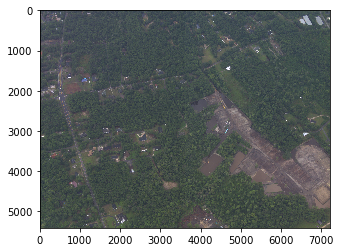

In [42]:
img = matplotlib.image.imread("/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047394.jpg")
imgplot = plt.imshow(img)

In [43]:
#and we can look a the image done outside a loop to see if it lined up with the numbers
TestIm = "/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047394.jpg"
TestIm = tf.keras.preprocessing.image.load_img(TestIm,target_size = (TARGET_SIZE[0], TARGET_SIZE[1]))
TestIm = tf.keras.preprocessing.image.img_to_array(TestIm)
TestIm = standardize(TestIm)
TestIm = np.expand_dims(TestIm,axis=0)
TestPred = model.predict(TestIm)
TestPred.shape

(1, 768, 1024, 4)

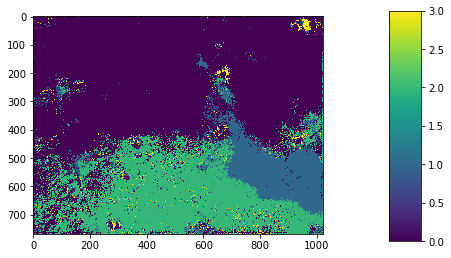

In [44]:
#these are the actual indicies, thes classes (whcih we get with argmax)
am_input = TestPred.squeeze()
lab = np.argmax(am_input,-1)

# plot the fig where water: 0; sand:1; veg : 2; dev : 3

plt.imshow(lab)
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

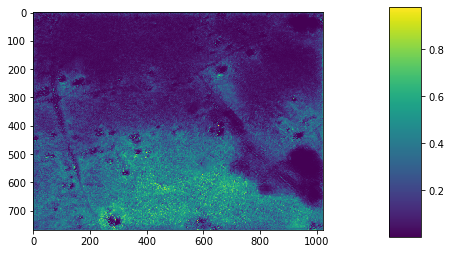

In [48]:
#we can look at the softmax scores for each class (water: 0; sand:1; veg : 2; dev : 3) 
SL_pred = am_input[:,:,2]

#SL_pred.shape
plt.imshow(SL_pred)
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [49]:
# now the next goal is to find the top 2 predictions at each pixel
# we use sort for that
sortedPreds = np.sort(TestPred.squeeze())
TopPred = sortedPreds[:,:,3]
SecondPred = sortedPreds[:,:,2]

LConfidence = 1 - TopPred
Margin = (TopPred - SecondPred)

#the worst pred will have a largest Least Confidence
print(LConfidence.mean())
#the worst pred will have a smallest Margin
print(Margin.mean())

0.3885208
0.4260211


In [ ]:
#yes, it worked..

In [56]:
#So now for a all the images
#first The PIL image file issue
#https://stackoverflow.com/questions/48395076/keras-giving-oserror-image-file-is-truncated-26-bytes-not-processed

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

    
conf = []
margin = []
img_name = []

All_pred_dir = '/data/NOAA_ERI'


for root, dirs, files in os.walk(All_pred_dir):
    for file in files:
        if file.endswith(".jpg"):
            #pull the image
            img = os.path.join(root, file)
            print(img)
            #pull the name of the image
            img_name.append(img)
            #process image
            img = tf.keras.preprocessing.image.load_img(img,target_size = (TARGET_SIZE[0], TARGET_SIZE[1]))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = standardize(img)
            img = np.expand_dims(img,axis=0)
            #make predictions 
            softmax = model.predict(img)
            #sort preds
            sortedPreds = np.sort(softmax.squeeze())
            #take top 2
            TopPred = sortedPreds[:,:,3]
            SecondPred = sortedPreds[:,:,2]

            #get the AL metrics
            iconf = 1 - TopPred
            imarg = (TopPred - SecondPred)

            #Save the mean of the image
            conf.append(iconf.mean())
            margin.append(imarg.mean())
        else:
            continue

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460605.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462750.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462059.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462018.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462952.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462739.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456479.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454513.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28456317.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455408.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462117.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28455787.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455362.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28455836.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462692.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455306.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460170.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462683.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462173.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455299.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28456352.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460235.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456290.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462903.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28461850.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454534.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462659.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28460311.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454004.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454306.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462558.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28453950.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455166.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28453869.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454072.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460306.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460172.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28455294.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462901.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456332.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28453932.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455793.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462003.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462926.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455898.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454680.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28463017.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28456280.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455313.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454933.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454835.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454284.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454396.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28453904.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460191.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28455935.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28453897.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462198.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28455829.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454808.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460404.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454864.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455475.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28460627.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454666.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462966.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460317.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455989.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28455385.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28461899.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28453969.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462537.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454337.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454445.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454806.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462458.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462664.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462938.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462194.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28461878.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28455238.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462923.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460647.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462418.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456241.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462493.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454242.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454459.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462972.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28460451.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462930.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456318.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454025.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454502.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28456429.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455828.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460142.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462680.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28461843.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462792.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454379.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460509.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462781.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454362.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455866.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454724.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454095.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456458.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455503.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460460.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455320.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28453837.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28453884.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462546.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454927.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28456287.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454288.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460628.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454369.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454361.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454841.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28456338.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462584.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28456301.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462783.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462525.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28455154.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28456462.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454481.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460383.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28456303.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456430.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455814.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460226.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455726.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454904.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28460613.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460598.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460565.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455149.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454498.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456276.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454932.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28456511.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28461875.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28453914.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460219.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454249.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456024.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454687.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462720.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28460486.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454439.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455226.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454898.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28453886.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454079.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28453985.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28462448.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28460556.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28460360.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462909.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28456413.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28454027.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454249.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28460530.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28456266.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28456381.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462678.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28455468.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454067.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455940.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28454351.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454857.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28456455.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28455835.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462409.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P28454404.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/C28462085.jpg
/data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S28462636.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477648.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476983.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477263.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481276.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478394.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478122.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479667.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480306.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482811.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478358.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479336.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476086.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479378.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28475939.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478334.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477849.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481662.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481549.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480425.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477608.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476478.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476033.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476414.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478769.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478977.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477245.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476574.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478886.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476567.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481578.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28475949.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480543.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481564.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482532.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478238.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477271.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478942.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476646.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28475887.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482996.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477674.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478375.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480558.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476581.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477564.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482551.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479063.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477684.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481275.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480172.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482790.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481543.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478413.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478358.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477507.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479954.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479560.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481452.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479035.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478752.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476084.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477624.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28482635.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477985.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477394.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28455331.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481466.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477276.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482923.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479035.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477640.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480516.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480459.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479303.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479675.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477416.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480376.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480720.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480530.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481444.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480726.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480397.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481374.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479324.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479701.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28475977.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476338.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481682.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480677.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482712.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481227.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477930.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28475712.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478825.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478993.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477980.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478689.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477532.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477678.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477797.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28482972.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478888.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476758.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480438.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480109.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476272.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479401.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482874.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478336.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477584.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478028.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480607.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477871.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480418.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479731.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482947.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482895.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479434.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477666.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482912.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28475792.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479422.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28475998.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477358.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479660.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480664.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478928.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480678.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476639.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478085.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28475813.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480354.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481704.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477889.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477191.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479807.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477618.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477521.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478442.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482818.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476205.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482862.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477753.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480019.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477179.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480068.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477503.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479000.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479504.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479070.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480376.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481395.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476091.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478282.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478986.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481303.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480087.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478661.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477432.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476695.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479925.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481542.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478049.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479681.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480179.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476331.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476387.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28475803.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480446.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482481.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480817.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480075.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479539.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478745.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477775.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477243.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478314.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478089.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480123.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480361.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478395.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482642.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477973.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480452.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478809.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481585.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476848.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477989.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477779.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479040.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477873.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28475736.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476784.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479885.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478874.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481459.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479827.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476135.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28475866.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477259.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480047.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479899.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477624.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481262.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482869.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478421.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480600.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480474.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479666.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481254.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478069.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478292.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28482727.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482600.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482933.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477360.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476681.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477700.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476800.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477845.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478734.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478324.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481508.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478194.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476693.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480551.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479883.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477634.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479934.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481472.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28455324.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28481312.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480643.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478206.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480628.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476477.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478048.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477929.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477714.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477717.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479019.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28475816.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477539.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479729.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476037.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481528.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477284.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478006.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479842.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477705.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479373.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476904.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478393.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480382.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482645.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477877.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478818.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479469.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28482680.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482951.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28482853.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476195.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477815.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476742.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477767.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476793.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480537.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479696.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477847.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478001.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479829.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476161.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28480277.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478839.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478649.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477881.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478433.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478367.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477452.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478867.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477422.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479499.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28475789.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476070.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28475743.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479366.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478642.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28482551.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476182.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478930.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477855.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481331.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476345.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477689.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476560.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28475757.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477264.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28475932.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478418.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478143.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28478135.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479806.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28479583.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476238.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477676.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478895.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481219.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479604.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478298.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478118.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478811.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28479506.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476505.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477696.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477336.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478081.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476282.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28478755.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477602.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28482881.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28482692.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28476751.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28480201.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28477716.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28476014.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480803.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28478177.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28477817.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476131.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481514.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477883.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480234.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481325.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28480810.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479743.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28476553.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481535.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28475824.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28479687.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/C28481689.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/S28481507.jpg
/data/NOAA_ERI/Delta/20201010c_jpgs/jpgs/P28477223.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465479.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464220.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465326.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463922.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457320.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463615.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464026.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464935.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457215.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464597.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28459562.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28459460.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464650.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464609.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458049.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457371.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464905.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458768.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458834.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28456885.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464939.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465624.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464192.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458613.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464730.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457145.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465368.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458493.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464442.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464307.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464283.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464771.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463637.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465556.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458536.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465517.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464949.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465577.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28456825.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463757.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458063.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458412.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464223.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464068.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465278.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457781.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464044.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465459.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458942.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464855.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464660.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458802.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463765.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463545.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28456641.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28456591.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463749.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457991.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464823.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459009.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464691.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465567.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465451.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464020.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459518.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465467.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463556.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464233.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464048.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464621.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465046.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28457222.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464175.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459328.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463552.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464815.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457583.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463741.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463821.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457236.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464501.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464732.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463858.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463929.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464200.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464263.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465464.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464260.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465460.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458452.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463954.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465167.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463551.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464644.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463732.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464647.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463883.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464183.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28457880.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465586.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464722.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464847.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464752.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459454.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464253.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458607.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457336.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458809.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465358.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465384.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464807.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463629.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464515.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463898.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459595.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28457810.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28459471.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28459601.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465064.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463855.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464128.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465238.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464452.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464756.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464434.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465320.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465053.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464408.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457501.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458077.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464135.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464700.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464747.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464684.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28457943.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28459612.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465348.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28456613.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464131.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465390.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28456648.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28459558.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465199.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464110.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465343.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463503.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464683.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465127.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458830.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465073.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457839.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465608.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458161.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465074.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464743.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463862.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464875.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464288.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464899.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463844.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463992.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28459513.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28456582.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457865.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458826.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464457.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464957.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458021.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464111.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464541.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465632.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465211.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464349.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465545.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458595.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463768.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464714.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463942.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458391.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463885.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463820.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464632.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463913.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28456542.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457853.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464104.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457534.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463810.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457942.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459093.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463632.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464106.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464502.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465529.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465489.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457508.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464072.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459065.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464201.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28457992.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464490.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465405.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464655.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28459275.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28457334.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464425.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28456717.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457796.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463831.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459405.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28456521.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463564.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464377.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465276.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464981.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464474.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28459587.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458726.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457329.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28456577.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465568.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463577.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459440.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458915.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457285.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458384.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459058.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464664.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463702.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458522.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28458388.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465420.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463786.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465618.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465426.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465044.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28456710.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464400.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463737.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28456814.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464389.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465298.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464698.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457152.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465484.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464595.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465056.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464318.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463798.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28457119.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465091.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465496.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464373.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464912.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465084.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458473.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28457789.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28457998.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463760.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463970.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464381.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464678.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465030.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464275.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464746.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465157.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464244.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459293.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28457362.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464173.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458459.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28456584.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463674.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464777.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465161.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465013.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464472.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463541.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28458126.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28459474.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28456811.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463698.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464229.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465154.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464059.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465604.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465432.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458174.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464563.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28458944.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464911.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463607.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28463851.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28464478.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28459098.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463555.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28464179.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465364.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465634.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28465081.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28464535.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463801.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465143.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/C28463733.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28465249.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465360.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465223.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/S28463502.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465002.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28459433.jpg
/data/NOAA_ERI/Delta/20201010b_jpgs/jpgs/P28465638.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574174.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572792.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570672.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572286.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570181.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28575038.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570219.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571557.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571880.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570590.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571585.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574815.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570413.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571263.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572801.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28575054.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570163.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573765.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570233.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572910.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572475.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570073.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572796.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572998.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574150.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574102.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571199.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572712.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572423.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570213.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571195.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571340.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571323.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571950.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572905.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570831.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570041.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573764.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571547.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572591.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570063.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28575107.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574230.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571149.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572298.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572620.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572937.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572306.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572131.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572469.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570852.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573852.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571954.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572403.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570383.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572567.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572930.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571187.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572612.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570787.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574049.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574260.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572680.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570253.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573012.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571962.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570759.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571976.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571690.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570347.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571173.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570493.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572376.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572354.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571598.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573737.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571942.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574147.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573015.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28575175.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571824.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571291.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573874.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572099.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572628.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571259.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572362.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570061.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574099.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574825.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570282.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570478.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572225.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573920.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574956.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28575101.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573973.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574090.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573735.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28575024.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573989.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570559.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572831.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571495.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571868.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574970.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571374.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570668.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574155.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570517.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572301.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573028.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572137.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571487.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570604.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572560.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573759.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570857.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574158.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571756.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570534.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574234.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571187.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573890.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570398.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570614.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574057.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571771.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573042.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572829.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572223.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570646.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571551.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574118.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574794.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571434.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570783.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572548.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28575165.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572388.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572817.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572113.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570275.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28575100.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570282.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572839.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570455.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571519.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573747.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571539.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570198.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574839.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570177.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573739.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571424.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572640.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573781.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570419.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571996.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573735.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572109.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570835.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570346.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571354.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570775.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574928.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28575093.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570501.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572527.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573900.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572016.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570574.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572370.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570087.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572847.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570594.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572662.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572308.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572531.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574182.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572849.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574166.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570534.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571904.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571283.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573878.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571189.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571225.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572821.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572710.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572407.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571157.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572945.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572813.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574045.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570117.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571575.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573796.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571543.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572890.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570819.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570753.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28575153.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574126.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570484.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573004.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570090.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571463.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570518.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572763.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573711.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570374.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570041.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570130.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573978.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28575145.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570550.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573006.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570566.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571465.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572825.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570303.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574827.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573985.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572000.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572276.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573965.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571738.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570278.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570141.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574994.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571106.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573832.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572857.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572447.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574204.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573862.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572604.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572233.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574230.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572672.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574984.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572636.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572618.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571887.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573715.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571359.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571840.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572503.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572465.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570195.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570630.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574280.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574069.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572193.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571980.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570608.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573870.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570326.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28575068.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571710.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572886.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571098.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572219.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571307.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573040.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571807.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571781.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570592.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570358.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572632.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572153.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572866.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570606.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572929.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571888.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570466.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572313.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28575091.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570881.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570646.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572722.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570853.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572922.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572682.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28575135.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574931.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572958.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570817.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570299.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570221.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28575020.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571664.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573043.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572129.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571956.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572394.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574251.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570049.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574968.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572189.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572953.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573036.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572272.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573813.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574176.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570210.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574849.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573864.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574029.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574837.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570654.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571656.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570231.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574190.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571403.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28575014.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572902.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574102.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574236.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571525.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28573785.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572887.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572153.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28574271.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570150.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574272.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574134.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574895.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28574220.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573880.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571396.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572201.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570715.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28571885.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572515.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570827.jpg
/data/NOAA

/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571449.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28572292.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572081.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571300.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570543.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28571972.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570089.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572249.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28573755.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570554.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/S28570242.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28574907.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28572061.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/C28570442.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28573824.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28570026.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28571565.jpg
/data/NOAA_ERI/Delta/20201011a_jpgs/jpgs/P28572157.jpg
/data/NOAA

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558726.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28553530.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28554744.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558863.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554076.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28553780.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28554082.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558880.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28553371.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558793.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28560182.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28559050.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28560298.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28556615.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28553622.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28559928.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558014.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28560162.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28553620.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557994.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558729.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28554254.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558669.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558476.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28555415.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28553850.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557553.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558579.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28559693.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554266.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28553259.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554126.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28555857.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554426.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28554444.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28556710.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28561071.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28559090.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28553551.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557914.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28556805.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557716.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28553540.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28555645.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558379.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557202.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28559053.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557824.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557182.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557406.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557275.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28556962.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557586.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554216.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28560922.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28560401.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28559887.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557506.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28556235.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557954.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558047.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28554452.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28555877.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558074.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28555518.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557453.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558034.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557125.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28560992.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557242.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28560419.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28553650.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558552.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557874.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557946.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28560811.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557295.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557062.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558104.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558930.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28560881.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28559058.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28556693.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557132.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28555567.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28560870.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558873.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28555867.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28554474.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554687.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558469.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557513.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557092.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28553411.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28554204.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28554083.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28555715.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28553640.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557974.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28556740.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28555426.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557663.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28555718.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557292.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28555758.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558429.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557443.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557122.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558496.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28556620.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557994.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28554624.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28553862.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554737.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558336.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28553289.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558499.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558349.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28555475.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28559164.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28555898.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558950.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558993.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558466.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28555665.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28553680.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28556720.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554256.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558807.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554226.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558094.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28554143.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28554482.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557396.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28559083.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558492.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28559673.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557766.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558034.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28553650.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28560829.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28559110.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28553251.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28560869.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557313.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557423.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554146.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28553510.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557493.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557486.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28560238.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28553219.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558024.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28560830.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28559814.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558696.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28559857.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554316.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28560899.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28555878.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554536.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28561081.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28556992.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28559736.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554586.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28554396.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28560819.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28559080.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28553460.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28559763.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28554582.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28558970.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28555557.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28553520.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557426.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28553330.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558636.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28558356.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/C28557386.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28559104.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28558843.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28556830.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557012.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28559078.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/S28557803.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28557753.jpg
/data/NOAA_ERI/Michael/20181012a_jpgs/jpgs/P28554322.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28571235.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574361.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28571840.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28570749.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571337.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28571246.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28572109.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574612.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28576529.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28576192.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573222.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28571483.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575912.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28576086.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571227.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28572711.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28573575.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28576352.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571387.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28573414.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28576620.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574860.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574743.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575437.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28573715.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575597.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573813.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571538.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575072.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28570791.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575043.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573823.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575926.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28572459.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28573535.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574902.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28575604.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28576002.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574783.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28572373.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573512.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28571242.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571816.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28572806.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28570889.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28572001.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28572886.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574670.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574822.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28573794.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28572731.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573743.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28571968.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571417.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28576532.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575489.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575427.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571951.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28572705.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28571376.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574511.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28572775.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574690.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28570821.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28573255.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28572069.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28570909.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571961.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574943.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575747.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28570759.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28571496.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573733.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28573335.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574792.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574462.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574542.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28573905.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575063.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28573734.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28571958.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28570782.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575529.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28571416.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28572631.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28570702.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575717.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574450.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574472.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28576046.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573282.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575459.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574642.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571846.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28573374.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28572911.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28570829.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28576522.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573592.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571518.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28570831.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28570859.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575092.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28575916.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28570952.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28571781.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28573525.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28572313.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28576186.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28570881.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573192.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28575684.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574662.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28575544.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571327.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573582.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28576112.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28576344.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574981.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574362.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28576242.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28570959.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28575996.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28576106.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574551.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28572811.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574550.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574733.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28573442.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28576519.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574420.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574971.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28572901.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574702.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575539.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28574703.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574401.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574650.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28575764.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28575002.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28571466.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28574830.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28573032.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28572962.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28571785.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28575474.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575649.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28574862.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/C28575589.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28576016.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/P28572681.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28570962.jpg
/data/NOAA_ERI/Michael/20181012b_jpgs/jpgs/S28571623.jpg
/data/NOAA_ERI/Michael/20181012

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768137.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28770315.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28767416.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28760148.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28759473.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763902.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770640.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28768787.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28764893.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28770191.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763852.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28761797.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28767054.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28758100.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766874.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768392.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768352.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762514.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28767034.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28765563.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763197.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766417.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766327.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770540.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28764905.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28760115.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28760798.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28764844.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768528.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763257.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28759422.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28758029.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28760928.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28767705.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763318.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762689.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28759014.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763932.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28761877.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770703.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28769381.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762118.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768598.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28765624.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28764202.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762255.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762201.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766004.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28763859.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28766866.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762058.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28758632.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28759469.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28760145.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766057.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28761898.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28764122.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768568.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762556.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762779.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762098.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762791.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770062.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28763949.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28764933.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28766289.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28763592.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28770270.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770008.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28764130.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28763494.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28759132.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28765414.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768372.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28759136.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762366.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28757954.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28761074.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766324.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768292.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28761457.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766834.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762691.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28767646.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28768254.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768790.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762647.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28765481.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28758737.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28767305.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28765373.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28766199.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28764830.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28766370.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28764140.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28761054.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28769139.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762586.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762811.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28764840.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762498.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28769171.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28765433.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28763474.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762767.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28769486.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762649.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28758672.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28763253.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28767626.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28758115.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28760914.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28758636.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28768114.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28761706.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28763988.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28768424.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762743.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28760934.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28765712.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28765483.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28765331.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768870.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28765722.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762502.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770080.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28770378.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28759448.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28765744.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28761586.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28764069.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762037.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762280.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28765673.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28764882.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28770049.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768192.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770414.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28770006.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766894.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28767676.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768402.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768628.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28770470.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28759402.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766207.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28767765.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28769211.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28764172.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28767706.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768418.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28761517.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28767224.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762018.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28758039.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763882.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28764138.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768157.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28764772.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28763958.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28767595.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770243.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770180.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766948.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28767546.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28766836.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28757974.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28765434.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28760953.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762562.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28757944.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28760127.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28758125.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768860.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28763442.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28766460.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28760938.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28758024.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28766876.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768247.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768730.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28760883.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766778.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28759498.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762138.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28765784.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768362.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28769135.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766137.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28763979.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762412.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28759533.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768162.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28769451.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28759126.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763368.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762430.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28765631.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770622.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28761948.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766047.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766294.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28768414.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28767107.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28759156.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28764170.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28765634.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770694.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28764794.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28769341.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766824.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28769827.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28763392.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768197.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28769181.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768257.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28770434.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28768274.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762097.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28770022.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28761452.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28769275.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766934.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762731.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28760157.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762664.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762610.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28767429.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28762492.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762689.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28770452.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28761024.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768468.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28757994.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28765343.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28767259.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28758150.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766828.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762496.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762268.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28759429.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762749.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28758743.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28758657.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762388.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28769765.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28759468.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28762701.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762171.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28765451.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28768382.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28767610.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28768227.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28761908.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28763353.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28761897.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28770387.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28764644.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28766357.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28764579.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28769366.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28762232.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28763502.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28763298.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770450.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28761527.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/P28764059.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28766134.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28763522.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28761617.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/C28770351.jpg
/data/NOAA_ERI/Michael/20181014a_jpgs/jpgs/S28761626.jpg
/data/NOAA_ERI/Michael/20181014

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28659785.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662026.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28663579.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665195.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663794.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660756.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28665459.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661996.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28667165.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662510.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28655533.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658569.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663802.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662857.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28657117.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658190.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665537.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662817.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28665677.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663351.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662730.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661267.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28663489.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663192.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663713.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28666268.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28655647.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28657704.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663493.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658439.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28659845.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28664644.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662221.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658649.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662110.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28655948.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28666907.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28655068.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662992.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28664073.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660486.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660115.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28656845.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663531.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662291.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660406.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663243.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28666937.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28657446.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28657512.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28657257.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661357.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28657197.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28664174.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662912.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28657081.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28657246.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661578.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28664044.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662780.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660896.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665607.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28663499.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662369.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28664734.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663343.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658900.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28665509.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28655128.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662056.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28665687.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28655048.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28656881.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663020.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665698.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663822.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660976.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28655543.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28657247.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28655240.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28657167.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28667169.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662702.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661087.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28666997.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28657436.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28664013.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658060.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660466.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662186.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28661960.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28663258.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665125.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661067.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28667198.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662792.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663683.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660526.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28664624.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28667119.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658850.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662601.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658800.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661247.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28656915.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660806.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662511.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665224.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662690.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28663188.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28659624.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28659040.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662359.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28656003.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28656991.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28666808.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662560.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663261.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28664213.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663423.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661856.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28666939.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28658951.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28664053.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662521.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28667178.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28657186.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658830.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662910.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28657321.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665858.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28655179.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662892.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28656947.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662627.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28665790.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28666277.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28667185.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28664794.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663874.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28665629.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28665750.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28667135.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28665597.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663301.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28663569.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28667109.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28664154.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28667137.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661377.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28657467.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662930.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663151.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28655088.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665828.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662902.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662968.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28665689.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28661858.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662842.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662231.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28657307.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28659825.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665738.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28657196.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662732.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28667007.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662682.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28655489.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661417.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663681.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662339.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660355.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662727.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660285.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28657552.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28661890.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28663128.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662407.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28664834.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28664164.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661217.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28664925.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28667079.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28657071.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658000.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28661930.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662950.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28665797.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28657506.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28667147.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28663218.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28663191.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662211.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28656053.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28664104.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663122.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663473.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28666955.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28659815.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28665807.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28665870.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28661820.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28665507.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28658609.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28662427.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661986.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28656016.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660105.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660776.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28662059.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661237.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28657236.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28665617.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28663072.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28664135.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28660886.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/P28661796.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28655269.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/C28658921.jpg
/data/NOAA_ERI/Michael/20181013a_jpgs/jpgs/S28662361.jpg
/data/NOAA_ERI/Michael/20181013

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460615.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471067.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467101.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468819.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465643.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28464619.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460344.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468267.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471695.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471456.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470389.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462561.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467011.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28465821.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461276.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460034.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460204.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28470057.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464939.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471321.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468826.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468543.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467978.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28464765.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28466724.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28463002.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465633.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468056.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471438.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28464839.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471322.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466861.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468803.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462861.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466656.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469627.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28467442.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469394.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28470606.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461046.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471294.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28469515.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461557.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465483.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468437.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466968.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28465872.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28463756.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465904.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466771.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471666.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468502.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466945.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468044.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462411.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466938.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468917.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470862.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28467103.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28473773.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28466826.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469928.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28473743.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28465531.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28465025.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28465852.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471015.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467398.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460655.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471342.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471435.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468069.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468322.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466530.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471474.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28470474.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460244.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28470919.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28464695.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469382.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469605.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462761.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466794.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471396.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28467786.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464779.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28469049.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461667.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469895.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461526.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468976.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466596.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466687.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467053.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468310.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471498.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470630.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471357.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466854.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28474204.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464254.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28467840.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471684.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469609.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468473.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28463456.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28474435.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28463012.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461737.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468292.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460334.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468797.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28464779.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464879.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467936.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28464845.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471003.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28465771.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462781.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461416.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469525.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468868.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462962.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28466562.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464919.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28463596.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462441.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28473733.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28469926.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471694.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462741.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461396.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469964.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28467383.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468911.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461136.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469580.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28463796.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28469641.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469958.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462431.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28465691.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471951.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28464509.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471732.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28463776.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464809.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28464990.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471969.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461617.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467392.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28470480.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471949.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468093.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471570.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28470051.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460765.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469635.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28464735.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471646.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470892.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28470526.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465893.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28465461.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469024.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28464950.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28470828.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468244.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461316.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464345.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466825.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28465912.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28464685.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460965.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471546.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28464869.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471701.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466831.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28472035.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28459846.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468443.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468886.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466860.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28473603.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468508.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471963.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461997.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467107.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469544.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471683.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28470846.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28470544.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28465055.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469388.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469466.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28470552.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28470468.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468958.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460755.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470606.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469006.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469018.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28463526.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467374.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471575.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28465882.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468333.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468904.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468021.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464749.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28465039.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469925.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470491.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28467961.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466735.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468953.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468423.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28466664.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468807.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28473794.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469916.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466891.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468928.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469985.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468418.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462340.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468521.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28465701.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460635.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469024.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28464875.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471297.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471279.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461216.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469543.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469454.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464104.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469398.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461146.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464568.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468490.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28464909.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466842.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460084.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28465591.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467047.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469979.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28469359.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465853.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28470520.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28464910.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471485.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28473814.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468545.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28467041.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461106.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28472023.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471652.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466590.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466884.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28467083.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28466808.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462921.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28461296.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468243.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28469538.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465603.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28466941.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28464925.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28469464.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28471479.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462007.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466722.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28469938.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28465731.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28470052.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468221.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471534.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468334.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466620.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28466705.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470437.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28467900.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28467930.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468008.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28470931.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28467966.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470575.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28467882.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28466764.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28471598.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28460254.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468256.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468934.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468765.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28467816.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28470533.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28466580.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28471999.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/S28468934.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28462380.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28468111.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465473.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28468527.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/C28469677.jpg
/data/NOAA_ERI/Michael/20181011a_jpgs/jpgs/P28465833.jpg
/data/NOAA_ERI/Michael/20181011

/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771308.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771353.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771356.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770464.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771305.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770499.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771283.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770585.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770600.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770479.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771130.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770444.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770615.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771071.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770776.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24770996.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771265.jpg
/data/NOAA_ERI/Dorian/20190904a_jpgs/jpgs/P24771

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956787.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954448.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24957243.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954392.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956364.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952838.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956562.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953147.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955469.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953105.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953366.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953394.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954440.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955693.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955256.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953332.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954034.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955102.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954481.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24957370.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957123.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953395.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955349.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954286.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954467.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955588.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953963.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954005.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953226.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955446.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953205.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956421.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954357.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24952939.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954469.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957031.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953935.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953091.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24952890.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957291.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956336.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953169.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956961.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956555.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955427.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954300.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955228.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24957032.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956210.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957382.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957375.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956534.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954342.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955426.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956997.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957165.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953900.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954504.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956990.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956759.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954216.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24957348.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955179.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956399.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955362.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955006.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24957278.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953557.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955497.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954497.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955448.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953269.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953599.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956919.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24952827.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953099.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955104.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955144.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955011.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956743.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953261.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954544.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957235.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955005.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24952910.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956484.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956526.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954321.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956771.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956919.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955328.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953255.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953248.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956934.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954082.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955621.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953526.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956323.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955546.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955412.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957340.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956295.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953247.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954530.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956519.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953303.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955651.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24957215.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954376.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955019.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954160.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955448.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24957208.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955055.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953213.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956484.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953406.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955644.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953350.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953582.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954089.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953561.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952908.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956274.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956997.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953324.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954497.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956962.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953353.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955462.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953101.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24952945.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953487.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955581.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955511.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955109.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24957384.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954046.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953329.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24957045.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953620.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24956434.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953961.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953171.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24952869.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24957180.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24952992.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956316.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956738.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956449.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953030.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954997.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24954237.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954

/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953998.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24956773.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955664.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953085.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24956877.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953975.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953445.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24952839.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24954265.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24954228.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955069.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24953435.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24955553.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24955081.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955673.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/S24953360.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/P24953926.jpg
/data/NOAA_ERI/Dorian/20190906a_jpgs/jpgs/C24955

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852064.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854428.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858437.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858654.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858570.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856812.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852646.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24861122.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24853672.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24853904.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857471.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24860446.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849652.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24860764.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854781.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857928.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851211.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24861

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850846.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852240.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848607.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849603.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852565.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859825.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848390.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850930.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857331.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850053.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862276.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849308.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851704.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24860827.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856692.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859776.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848789.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851407.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852910.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850748.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856137.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852678.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851504.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859881.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851624.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857289.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848754.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862416.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850207.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852048.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857085.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850621.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851218.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24860071.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849807.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851848.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854549.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855955.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854653.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24861650.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849919.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859054.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854056.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858528.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849273.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848859.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859966.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857942.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854589.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850684.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851155.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855365.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851253.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858584.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848803.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24860327.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856004.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849006.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862311.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862837.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24853022.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862999.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854348.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862746.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850003.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857556.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849512.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852726.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24861

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858823.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24861313.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24853166.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859657.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24860355.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24863013.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849294.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858423.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859090.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862936.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855660.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855765.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859664.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862606.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854805.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859685.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862177.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852934.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850993.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862781.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854677.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857015.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24853864.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852136.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857956.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24853078.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24861573.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857935.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862886.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859818.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848677.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24860848.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857366.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856776.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24861150.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849091.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857486.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850312.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856489.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858394.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857177.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856088.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859594.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859012.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862858.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856980.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24860383.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857921.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854573.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857598.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859019.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850017.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854088.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24861383.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855836.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24853768.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855548.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856783.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855800.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849210.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855899.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855541.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850067.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855829.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24858640.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848726.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848341.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855990.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852862.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24862774.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849203.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856025.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849400.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848495.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856278.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851099.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848705.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856102.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857141.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854048.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856046.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24848880.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851632.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851176.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854492.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24854

/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851824.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24851520.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849624.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24859033.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852208.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850024.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24852694.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850600.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856952.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850305.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24849842.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850832.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24857078.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850635.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24855997.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24850031.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856629.jpg
/data/NOAA_ERI/Dorian/20190905b_jpgs/jpgs/S24856

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250238.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253419.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254956.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258683.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254523.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253743.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26247733.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252737.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253966.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252048.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252800.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251470.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252346.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248157.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254490.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26247759.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253847.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255014.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253890.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253840.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252739.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251991.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26255632.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255671.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26249603.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253332.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250202.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253866.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255608.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252350.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254343.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253298.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252374.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254441.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252548.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26257644.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253934.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253210.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26255555.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254825.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258809.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253278.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26257523.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253735.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254516.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252646.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26249069.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253406.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26248263.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255572.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251413.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248906.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253158.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251289.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254537.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258650.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254331.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26255610.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252595.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250323.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26248976.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254991.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253975.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26250188.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258176.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253377.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252550.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26248584.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252135.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250191.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250373.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258011.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252552.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253817.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252233.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253905.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26248268.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254269.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26257512.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252662.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253767.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252247.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253442.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256180.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252264.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252166.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253916.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254557.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252595.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252746.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26255664.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26247735.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248577.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255628.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252760.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253320.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26255563.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254513.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258723.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248552.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254244.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252174.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253759.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253212.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26256326.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251436.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255556.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252197.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26250474.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255735.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252821.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252335.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253830.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26250215.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252064.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26247250.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258739.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254566.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26255684.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254264.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253920.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256173.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252243.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253378.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258718.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258862.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252811.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26256692.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258054.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252789.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252074.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254926.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26255618.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253719.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254870.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251486.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251411.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253230.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254835.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248222.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251353.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254413.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248507.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253379.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251495.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258699.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256298.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26249588.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253260.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26256171.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252043.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251299.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258678.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250245.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250549.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26249597.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26255604.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251380.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252170.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254974.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253917.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251519.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252062.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253852.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258222.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253812.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251550.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250231.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252186.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254889.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251374.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253913.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255747.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256191.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252680.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250149.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26247743.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252049.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256194.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256265.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254988.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253414.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254485.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26257561.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254865.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250345.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26257626.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254393.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250369.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252164.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252019.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252272.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258217.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252664.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256220.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255063.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251501.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26248213.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26255026.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253286.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252284.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254372.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253401.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258239.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258211.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258038.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254869.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252856.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251287.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258681.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26248269.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251418.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252278.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252111.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251990.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254305.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253872.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254885.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26247270.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26249031.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250435.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26256

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252555.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251386.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251366.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26249636.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253407.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252755.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251282.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250253.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258819.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26257632.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254949.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253793.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26256680.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254854.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252154.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252115.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258154.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26255

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253471.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26256255.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253415.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252213.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251571.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255651.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252094.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251480.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26247692.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251517.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251462.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253886.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251432.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258671.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250422.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258878.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253488.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254405.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258105.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255635.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250280.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253256.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26250382.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250532.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250207.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26248599.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254847.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250310.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252231.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26249608.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250433.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253742.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252697.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252202.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252178.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258155.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26256252.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258182.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26250242.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258093.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252361.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26248556.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26250175.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26257442.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250349.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26257671.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254248.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253944.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258193.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256213.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26255064.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26257

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26255692.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252227.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255075.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254573.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254859.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26258045.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255078.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26249056.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254430.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253955.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252674.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248936.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251349.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253861.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26248541.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254533.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254424.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26257490.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252272.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258708.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253397.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252295.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252581.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253441.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252606.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253704.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26257588.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252119.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26255024.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26255062.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26250313.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26252753.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252752.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26248203.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251273.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252262.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254539.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251514.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26257579.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26251488.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254376.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254302.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252060.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252834.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26255703.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26256724.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248537.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254981.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252671.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26255658.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252702.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252023.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26250316.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26250206.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26256837.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26247676.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252788.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26248542.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250151.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252213.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252054.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251434.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252149.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252190.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252808.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26252033.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254976.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26257995.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252

/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26251382.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26249073.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252096.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26253757.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26250437.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26248274.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254339.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26252805.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26248275.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26251576.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253166.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26254483.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/S26254882.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253327.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26254765.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26258813.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/C26253337.jpg
/data/NOAA_ERI/Dorian/20190919a_jpgs/jpgs/P26253

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057041.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054926.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055994.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058857.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055929.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054241.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058637.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057626.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055347.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058069.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055459.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055368.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057872.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054447.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055922.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057495.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25053768.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058546.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057018.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056949.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055462.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058078.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057741.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25056920.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056935.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055245.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055172.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057556.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054097.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054234.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055938.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055663.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25053936.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057999.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25056

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055490.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058225.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057914.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054821.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055256.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055540.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058336.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055887.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058483.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054996.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057804.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057837.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057004.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054009.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058363.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058322.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054877.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055952.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055157.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058295.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054073.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054093.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056640.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054497.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054814.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25056885.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055441.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054947.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054975.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055104.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056542.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058314.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058693.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058631.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057979.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057937.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055010.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058097.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054837.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054961.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055635.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054481.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058103.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25056533.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058679.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056500.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054101.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057579.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057745.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25053711.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058798.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058321.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057830.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058490.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055273.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25053764.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057753.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058385.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055087.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055404.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057404.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055729.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058337.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058440.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054079.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055579.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057950.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055045.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057614.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054455.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057858.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057815.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057395.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054866.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057739.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055530.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057921.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055259.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055266.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055501.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054781.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25056057.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058280.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055508.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058511.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25056666.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058181.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058799.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055013.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058232.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25053799.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055011.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057790.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054196.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057034.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054185.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055719.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057409.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058392.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25053775.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056535.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057930.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057577.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054171.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055382.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055189.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054378.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25053869.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058694.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25053862.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25053690.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058485.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057619.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058576.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25056541.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057774.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054412.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055228.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055554.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25054069.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058307.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25053782.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25056647.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058370.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055945.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25053954.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057556.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25054827.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25055852.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25053848.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058785.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25056071.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25053866.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055466.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055088.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057724.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25055

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25056506.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058588.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058246.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057661.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054397.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25056701.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055340.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055333.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25057039.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057411.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056928.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25056457.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25053683.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057675.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25057907.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058589.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25054859.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25057

/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25055270.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/P25058595.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058780.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/C25058141.jpg
/data/NOAA_ERI/Dorian/20190907a_jpgs/jpgs/S25058638.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350805.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353494.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347648.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353000.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350406.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352484.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349138.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357861.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357918.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352962.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353953.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26351029.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353

/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346322.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349268.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350341.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350399.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348018.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353064.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349221.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347510.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348525.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26356545.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347478.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346318.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26356506.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26356633.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353371.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348538.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347551.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349

/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346848.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350822.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347524.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349974.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346295.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357336.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353885.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350467.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349695.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357825.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354784.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350312.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348719.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347996.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353075.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347359.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357366.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26355

/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346457.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346336.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354838.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347464.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352539.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349304.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346778.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348558.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26356517.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349210.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348010.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346299.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349738.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346253.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353525.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346203.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357287.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349

/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350924.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348634.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348082.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352501.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26356413.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353854.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349246.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26356616.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346967.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352973.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350916.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26355536.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353901.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349250.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352418.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350456.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353932.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347

/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346341.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353438.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348732.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346946.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348591.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354754.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354437.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346840.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349099.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354295.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357903.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346974.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354879.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346873.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349962.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352984.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357520.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357

/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348003.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353021.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354269.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26351037.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348787.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350359.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347403.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350337.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346953.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352571.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349196.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347960.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348617.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347514.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26346910.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354396.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348779.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349

/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26353412.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26349077.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352602.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26350882.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26347602.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348110.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26352951.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357306.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348595.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26354020.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26357913.jpg
/data/NOAA_ERI/Dorian/20190920a_jpgs/jpgs/C26348521.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050937.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050535.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051878.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053174.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25052883.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051

/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053630.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051371.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051260.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050690.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051098.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053560.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053110.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051267.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051976.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050803.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051526.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050409.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050684.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053419.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25052116.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051182.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051427.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052

/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051483.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053343.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052830.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053034.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052368.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053616.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25053241.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051365.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25052523.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051288.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050851.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050593.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051190.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25053220.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051546.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051609.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051246.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050

/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050663.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25053550.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051646.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051021.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051203.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050734.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051743.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050943.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25053262.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052340.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051862.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051856.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25053564.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050656.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050663.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051211.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051148.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052

/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052587.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051195.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051857.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051316.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050501.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052578.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25053557.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051442.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050979.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050951.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053237.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052108.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051176.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053356.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25052890.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053518.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051042.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051

/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050577.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051295.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25052011.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053195.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050853.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25053311.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052292.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053230.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053104.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053272.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050830.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051062.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050515.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053082.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053482.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053490.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052024.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052

/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051344.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052206.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051855.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052264.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050432.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052011.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050972.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051752.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052473.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050895.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050648.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052914.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051820.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051822.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052187.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050817.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051736.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051

/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053546.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053300.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051765.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052977.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050551.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051667.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051315.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052248.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051954.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050824.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051946.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051982.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25052151.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053090.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051548.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25051491.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051457.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25052

/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25053251.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051773.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051273.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052129.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25050396.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050907.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053399.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053322.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051104.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25052144.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052564.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25051209.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25053062.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/C25052025.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25050781.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25050712.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/S25051716.jpg
/data/NOAA_ERI/Dorian/20190907b_jpgs/jpgs/P25052

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24967400.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971850.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969125.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969243.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969230.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970550.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966585.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969277.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969088.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24966423.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970902.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969432.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966850.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24972796.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969236.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968545.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971829.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971078.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966711.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973070.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969707.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971394.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974620.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971302.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970360.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967886.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974969.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973538.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971513.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24972891.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973433.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973798.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971653.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24966592.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24964961.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973608.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24968485.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966738.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966668.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966618.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24964842.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974688.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965473.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973489.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974849.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965429.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965422.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970922.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973109.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973503.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965622.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967464.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965356.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974807.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969693.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970481.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24964898.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970557.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968559.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965110.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24967866.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973411.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970873.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971449.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969068.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966646.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971378.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965847.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970032.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24966395.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971119.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24967859.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24964872.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970185.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969123.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24964884.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973077.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974774.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970965.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969720.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973355.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965394.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24968035.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971112.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965812.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969418.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24972899.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973246.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24964904.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965375.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965415.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971373.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969663.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24968026.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969173.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966443.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24972902.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973481.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24964970.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970172.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970446.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970818.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971211.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965775.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965433.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973559.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971323.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968587.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970824.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965605.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967950.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965517.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969601.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24972849.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969545.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970908.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974302.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24964953.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970944.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24968

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965353.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970018.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24972895.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965080.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971162.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974898.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969207.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966773.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970585.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974386.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970599.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974634.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973861.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973115.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966500.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973091.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969335.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24967

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969355.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967288.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971127.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24972990.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965093.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965405.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971654.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969258.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967211.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974898.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970220.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969434.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971484.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971176.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973597.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969376.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969587.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971745.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974400.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970614.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24968047.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969628.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24972803.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970825.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965896.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973860.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970116.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974550.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974730.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966836.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971295.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970044.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969011.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968411.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24967936.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971043.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970481.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973460.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971147.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973615.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967703.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969018.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969263.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968516.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974802.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973505.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969264.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970065.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965033.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965894.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966662.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971261.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965304.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966353.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973746.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970713.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968488.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971275.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969123.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969158.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965528.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969483.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974669.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970690.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968991.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966690.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973039.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973545.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969835.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973144.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974632.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969588.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968062.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24968077.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974957.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967745.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970811.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967316.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970881.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973323.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973080.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967984.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970952.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969842.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965030.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971561.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968524.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24967344.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24967768.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969341.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973435.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24966815.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970725.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969356.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24964837.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969946.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965873.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965529.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967830.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965486.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970881.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970381.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970179.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967280.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969940.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974948.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973569.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967717.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24966648.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967218.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969132.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971359.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973337.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24968096.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24965816.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974753.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970416.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24966789.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974435.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970748.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969216.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971380.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973531.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973101.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24964939.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24972863.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971168.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967288.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974978.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969004.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973028.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974351.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970718.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24964967.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966507.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971647.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969686.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965368.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967781.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24974641.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967718.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973854.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967273.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970972.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24968431.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966788.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971308.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24972905.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24967844.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971113.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974358.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970866.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970467.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971471.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973446.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24971520.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969165.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970158.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969286.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973390.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969090.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970002.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969905.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970495.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24964926.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24972843.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969005.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971750.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973879.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965066.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24969856.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970081.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965650.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971408.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973889.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969580.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968552.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965782.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971505.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973881.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969074.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24970459.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973003.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970018.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969898.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24970130.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24971134.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24971

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974561.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967267.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974590.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24972954.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970580.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973844.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969208.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973914.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973313.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966844.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965278.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968460.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24966445.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974428.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24969383.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24964940.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24974954.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/P24973

/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24967394.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24965396.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970685.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24966746.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973239.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24969516.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966830.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24970502.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965671.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24966669.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973776.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24974793.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965854.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24965678.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24973306.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24973309.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/S24966325.jpg
/data/NOAA_ERI/Dorian/20190906b_jpgs/jpgs/C24968

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067668.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064466.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063278.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066107.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062719.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068278.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066077.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067524.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26060892.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066031.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061208.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061220.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067055.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061801.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063889.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061804.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063244.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068680.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066286.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067620.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066222.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061826.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068679.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066190.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061085.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063342.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062596.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066181.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26062588.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064589.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066118.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067514.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066826.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062524.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066121.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062847.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26060903.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066003.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26065991.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066796.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063952.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062543.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061764.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064108.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068544.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061915.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26060959.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066284.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063176.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061832.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063207.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064827.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063246.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063781.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061886.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26062851.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063308.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066991.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061031.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067498.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064009.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063329.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061174.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061205.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060971.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067710.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064774.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067070.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26065912.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067732.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063772.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061894.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063194.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060997.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067784.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066058.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067048.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068631.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067767.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064795.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063968.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064562.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064669.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061073.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067005.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062558.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063230.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062636.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26065931.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064076.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061865.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061219.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068487.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063807.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063408.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061906.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067528.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063262.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061039.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066223.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062694.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061919.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060823.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061766.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061091.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067615.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26060989.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063340.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066018.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063180.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064620.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063242.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063893.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061012.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066035.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067571.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062799.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26060853.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061920.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067546.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064611.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067453.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068664.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064756.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068447.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061689.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062683.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061738.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067728.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26062555.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061187.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26065931.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067554.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063359.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066301.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064701.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061883.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066295.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067477.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066838.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066284.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063950.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068482.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064676.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063884.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068540.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066952.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061734.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068478.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061112.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063943.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066842.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064705.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26060984.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067758.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064041.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064615.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060786.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067819.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26060882.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26062756.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062721.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061903.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066907.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060808.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066977.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064946.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26062535.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061729.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061201.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066072.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067789.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064806.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063822.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068572.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26060958.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061212.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066947.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068419.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066048.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068520.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064909.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064770.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060941.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063906.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064460.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068423.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062547.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063260.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26060966.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061096.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063422.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066061.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063976.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063942.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060816.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066010.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061778.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066938.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066040.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063757.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064863.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060860.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26065930.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066006.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066081.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061660.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063972.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061779.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068248.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067545.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063190.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063951.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064860.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064544.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067506.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26062618.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066929.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26060804.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066991.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26060988.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067503.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066790.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060912.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063299.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066080.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067815.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26066988.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061692.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063306.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063795.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061077.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064940.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062795.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063239.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063352.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063317.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064765.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068269.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061005.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063231.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063812.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26065969.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067511.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068366.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063762.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068515.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067445.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068391.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064820.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068560.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066186.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064506.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068430.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066912.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064533.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063803.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067470.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061706.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062595.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067814.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067676.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26060970.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066133.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068451.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067720.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066977.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063228.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061684.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062773.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061081.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26065911.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067444.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068411.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062755.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066083.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26065976.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067019.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061225.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064766.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066852.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064512.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061724.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068486.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26067611.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060930.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062715.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061790.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068522.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067698.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061162.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061201.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062841.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068583.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063302.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068721.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063365.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061203.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26068475.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063838.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061119.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26061925.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067016.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066033.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064498.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26065916.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26062547.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061020.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064660.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26067489.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066782.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26064644.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068700.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063218.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061112.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067741.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063889.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064087.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066288.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061775.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26068596.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26063333.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26067558.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26063

/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063758.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064078.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068344.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26068340.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26061075.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26060836.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26062665.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064632.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064525.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26061054.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064527.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26066145.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26064840.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26064472.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/P26063897.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26066159.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/S26060948.jpg
/data/NOAA_ERI/Dorian/20190917a_jpgs/jpgs/C26060

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155005.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152011.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157621.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156390.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152197.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152601.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152168.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154369.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155344.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157251.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155037.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156358.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157222.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156403.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153811.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152186.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155954.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26158175.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157784.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157240.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156354.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154875.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157705.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26151996.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155314.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156309.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155462.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152054.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153722.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155030.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157258.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155372.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153860.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152131.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157705.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157755.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155433.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156300.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153754.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26158137.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155979.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157156.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154352.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154385.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156377.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155965.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154360.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154928.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156258.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157774.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26158062.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155444.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152097.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155888.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156372.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152145.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154858.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155365.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153141.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155423.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155013.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153315.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157216.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155387.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26151994.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154428.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153702.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156832.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153312.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157649.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156893.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156281.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153797.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153771.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152485.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156410.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155399.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156333.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155020.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154922.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154422.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155396.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26158164.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153718.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155408.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157782.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153145.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156381.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156828.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156286.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153676.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152605.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152114.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153655.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153754.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155962.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156260.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154328.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152502.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157683.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153674.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155450.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26158

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155910.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153686.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153666.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157681.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156887.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154375.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152031.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26158194.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154481.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154391.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152137.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154426.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157617.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157193.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152530.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155924.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153726.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152526.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152554.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156880.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154418.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152522.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156344.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154913.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26158198.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156016.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156342.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157643.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153704.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153219.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154520.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153202.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156012.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152000.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152183.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157224.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153237.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155379.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154358.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26158042.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153787.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155469.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153718.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152193.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154326.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26158168.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26158134.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156028.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156295.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156305.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153856.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154970.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152108.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26158145.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153339.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156830.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26158094.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155880.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154909.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155940.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156026.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156758.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153765.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154405.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153145.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152624.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155437.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155437.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26158

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156803.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26158175.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157188.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152581.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152152.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152483.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156328.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156358.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155854.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152180.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154913.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157234.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157637.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152593.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157732.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26155942.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153750.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156885.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152019.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153647.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157631.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26156803.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156265.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155473.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26157174.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152193.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153258.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153250.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152642.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153151.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154334.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153852.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154957.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153860.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156867.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26154949.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26156417.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152649.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26153680.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26154477.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26155476.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26154862.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153321.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155464.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26158156.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157649.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26152077.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26153348.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26153758.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152560.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26156011.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26152

/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157750.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26152636.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/P26157780.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/C26155457.jpg
/data/NOAA_ERI/Dorian/20190918b_jpgs/jpgs/S26157665.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862602.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24852780.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849596.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854531.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852155.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848418.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862519.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24852315.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862412.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860797.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854119.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856255.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854582.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851955.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855500.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24853165.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858701.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848334.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851035.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860045.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850397.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848943.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849196.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849701.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850474.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852725.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851267.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856448.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855455.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856045.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862946.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854459.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851586.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856420.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849554.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851899.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851411.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850662.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862807.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24853583.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856062.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850648.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861670.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862356.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851466.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850606.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862974.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859901.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854734.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860326.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856848.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853641.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855834.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849631.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857417.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852589.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857470.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854654.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856424.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24859581.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852299.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849203.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858872.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848971.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850297.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851467.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858736.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852251.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848964.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857660.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851443.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850641.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851132.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852869.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861588.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857445.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860035.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850572.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854758.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860811.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850732.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862645.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857779.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859656.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856789.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850585.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849491.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850481.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860377.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856974.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857365.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849173.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856097.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860741.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861441.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849357.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849616.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850052.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860783.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849238.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853593.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24853655.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855816.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857098.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851007.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24863009.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856005.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24848451.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851771.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851979.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861106.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857014.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856651.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849581.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848859.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853705.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857339.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857016.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858998.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853945.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849293.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850656.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860888.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857002.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849912.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850992.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854310.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24852844.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854747.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852637.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858512.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861078.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862561.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859024.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857058.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853905.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858470.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854318.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858547.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858907.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857723.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850621.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862399.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850711.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854414.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862343.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856581.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24848570.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860056.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854331.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24852307.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850937.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855975.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853921.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853649.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851795.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862820.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851176.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858968.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851302.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851987.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850788.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859908.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862378.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24852283.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850655.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857690.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850734.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849835.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860671.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853929.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862644.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855921.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858563.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856356.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24859708.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854507.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24859932.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849433.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858982.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854675.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848446.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849849.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862300.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856497.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861382.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851498.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850923.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862968.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850986.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860552.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857849.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24859785.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851450.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24852932.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24863031.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849517.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862588.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24853149.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855710.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856827.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852709.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861148.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859585.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855996.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848327.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859936.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857617.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851723.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857681.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862673.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855813.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848824.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855785.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853769.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854063.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861071.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24848598.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850523.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851635.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852315.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861614.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849819.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861445.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854095.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856146.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856185.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856986.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854251.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860615.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854089.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858863.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858704.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850228.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24859701.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849498.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852653.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851155.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851539.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848775.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858540.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855862.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860685.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857276.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858374.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855746.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851351.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852853.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862315.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862238.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856157.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858877.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849737.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856691.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24853133.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860692.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860105.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862504.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857112.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857873.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852845.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857150.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849814.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857241.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850851.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856333.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853977.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857540.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852163.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861586.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860973.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854798.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849758.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856588.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24848353.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859726.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862491.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849056.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852139.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859866.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855584.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860063.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852307.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862553.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850500.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848810.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856564.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857080.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24853141.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849756.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862798.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24853157.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849588.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862624.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24848500.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24859986.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851691.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860818.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24848311.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856613.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851410.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852291.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860973.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24859925.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861572.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861291.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857105.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854699.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862518.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849329.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854630.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851523.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856887.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852179.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855448.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855654.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851827.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24857466.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24853

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857316.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850079.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861530.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850290.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849568.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858619.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860587.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851843.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861092.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24854294.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857947.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850207.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24862321.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848284.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856283.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850712.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849947.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24852909.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860391.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854145.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24863016.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858500.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850846.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849953.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24852796.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848614.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851939.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861553.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858456.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855659.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24851483.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24851474.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856960.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860678.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854539.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24862175.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849379.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24860643.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24861537.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24859666.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848922.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861057.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850495.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24848439.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24852323.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24860573.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24850262.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861623.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849342.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24856354.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855640.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857

/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849356.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856399.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24854587.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24861364.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858514.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849175.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24858673.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24853783.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24857828.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24850825.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849897.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24856757.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24849889.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/P24855715.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855472.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24849751.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24858465.jpg
/data/NOAA_ERI/Dorian/20190905a_jpgs/jpgs/C24855

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059786.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059169.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071338.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065189.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070242.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070401.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069761.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065734.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058706.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059328.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26068962.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26068756.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059147.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059907.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070484.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069810.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071451.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071451.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059465.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059235.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26068919.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071110.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059846.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070296.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060470.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070327.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060760.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059435.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069921.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059830.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071229.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060067.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071098.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071279.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26068809.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071215.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065730.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058589.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059361.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071447.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069578.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065666.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26064997.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060635.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069779.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065249.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058623.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071325.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060695.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065130.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069647.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070569.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065083.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059865.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059351.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070604.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060495.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065226.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070498.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070274.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059404.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060518.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071058.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070591.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070432.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065261.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058406.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071105.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070567.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26068729.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059250.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059217.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065051.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060756.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069849.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060764.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059487.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059910.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058578.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26068850.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059459.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065185.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069886.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060582.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060752.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069925.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069862.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060588.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071207.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065192.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070970.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058652.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070379.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065059.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069968.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059374.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26064981.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059800.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070491.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059938.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070573.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071424.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058563.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069972.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26064966.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070463.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059780.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060111.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065619.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060707.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071233.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060029.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069867.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065638.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059921.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070197.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059318.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060773.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058722.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059235.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071355.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058733.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068947.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071298.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071081.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058400.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069962.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065808.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060134.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070256.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068971.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059426.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060681.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058448.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060587.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070372.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069704.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065095.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070477.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059289.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059123.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069008.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060010.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26068789.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065716.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065879.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058517.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059320.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058733.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070011.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26068874.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070563.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065189.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26068

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070310.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069868.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070594.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065009.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059389.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065867.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069552.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069708.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058485.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071206.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26068867.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071408.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070452.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070330.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065862.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058644.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070225.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060505.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070428.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058388.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071320.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069673.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071228.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069643.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069515.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065680.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070243.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070323.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065098.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069876.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060111.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069596.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059853.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068863.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059894.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071010.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068847.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070264.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059387.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070983.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069558.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070418.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065727.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059231.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059432.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070286.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070462.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060096.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065758.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071028.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069536.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070028.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071302.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070335.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059273.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060686.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058452.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060674.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069757.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059166.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060510.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065061.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059121.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065688.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058610.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069880.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060014.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071198.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065126.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060510.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069687.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071072.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065850.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058428.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060091.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065677.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059173.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058368.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26060521.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26068852.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060145.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071122.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065286.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070393.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058440.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069845.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068777.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071038.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071416.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065241.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069756.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059413.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068800.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070553.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060130.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065609.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069600.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070978.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26068958.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059347.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069846.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059345.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068851.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070572.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071234.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26068776.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069639.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060690.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065042.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069976.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065246.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069800.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065057.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26064982.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058473.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065878.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069783.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071260.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059848.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065138.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059261.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071131.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070515.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069972.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058467.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068991.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26071153.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059265.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059153.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059121.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060560.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071296.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059810.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058632.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069797.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070231.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070577.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065700.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070383.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069967.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070584.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070263.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060611.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065168.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071382.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26059279.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060083.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071319.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069651.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26069837.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071442.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070410.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058650.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26060

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058384.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059942.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070979.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068963.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065297.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070345.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070997.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059129.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26064950.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059300.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070576.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058627.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26059969.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26058668.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26059983.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058698.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26069928.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065

/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071106.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071250.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071386.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26058475.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26070203.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26065050.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26070289.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26071097.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26065233.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/C26058662.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060551.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26071486.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26069854.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26060577.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065140.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26070007.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/P26068844.jpg
/data/NOAA_ERI/Dorian/20190917b_jpgs/jpgs/S26065

/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454694.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26453934.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454326.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454046.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26453952.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454230.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454195.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454527.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26453977.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454695.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454213.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454211.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454665.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26453941.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454364.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454501.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26453994.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454113.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26453923.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454076.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454640.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454686.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454189.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454278.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26453943.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454294.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454261.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454445.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454443.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454510.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454302.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/P26454704.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454308.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/C26454656.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454538.jpg
/data/NOAA_ERI/Sally/20200920a_jpgs/jpgs/S26454418.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279395.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26280167.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279140.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26282264.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26280111.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26280342.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279303.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26281394.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26282721.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26281413.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279114.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26281305.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26278850.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26282649.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279355.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26281510.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26281598.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279245.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279088.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279127.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279270.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26280230.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26280440.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26282555.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26280454.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279831.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26280054.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26281481.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279852.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279062.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279212.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279022.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26278876.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26281335.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26281501.jpg
/data/NOAA_ERI/Sally/20200918c_jpgs/jpgs/C26279322.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26278823.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279428.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26280222.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26282679.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26280418.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279782.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279858.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26278756.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26280488.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26281697.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26280188.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26281823.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279395.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26281755.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26282213.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26278770.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26282254.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26281305.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26280257.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26280146.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26281902.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26282285.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26280411.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279977.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26281814.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279342.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26282274.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26281384.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26282835.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279074.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279041.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279081.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279127.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26279461.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26282378.jpg
/data/NOAA_ERI/Sally/20200918d_jpgs/jpgs/R26281529.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266102.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262413.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262478.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269908.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268746.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26265945.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270297.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270414.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268649.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266109.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262752.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268900.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269536.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26265780.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267587.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26263264.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270964.j

/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268969.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267057.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268558.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26265816.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269922.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268704.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268329.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26261651.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266813.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269463.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268371.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266869.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262806.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262632.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262511.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270661.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266598.j

/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268669.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270455.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26263384.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267822.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269676.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268038.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26261032.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267971.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267085.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266994.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26261087.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26265917.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269990.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268962.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26264155.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266876.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270710.j

/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270564.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26264133.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268844.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267944.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267809.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270633.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26263844.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269306.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26263363.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268405.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266938.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270557.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268302.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270462.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266546.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269347.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268767.j

/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269368.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267829.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266734.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270654.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26265845.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270950.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270991.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268753.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262610.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26269962.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267208.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26263966.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267092.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262445.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266719.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270359.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268996.j

/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26263122.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267964.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266059.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267106.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26265952.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26268983.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26271012.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26263428.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26264045.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262795.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26267195.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26261098.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26265838.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26270269.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26263877.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26262697.jpg
/data/NOAA_ERI/Sally/20200918a_RGB_jpgs/jpgs/C26266088.j

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561551.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26551545.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560018.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560941.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563238.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26559956.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554756.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555350.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26553956.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26552463.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26565524.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563684.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557085.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561186.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558093.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554877.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558457.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563149.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556296.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552731.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560952.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561164.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558173.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26565579.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26553599.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557987.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554187.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552044.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26564956.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26562430.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556280.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552721.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557237.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26565864.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557130.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557228.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555461.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552540.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558812.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26557076.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26558776.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558139.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556314.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557157.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26552548.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26564946.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558365.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561818.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556801.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563203.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26554801.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26561009.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556135.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563067.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26564495.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552678.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26551634.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26562295.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563276.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563660.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565865.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555392.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552753.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26554409.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563230.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555553.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26556271.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558079.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26551670.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26553205.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563602.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26562520.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26560817.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26552846.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26560703.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26558952.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555703.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26559963.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26564605.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26552836.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563764.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26559328.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557164.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561869.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557121.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26555372.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557092.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561571.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552444.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556783.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26553435.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26561277.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552412.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556958.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563113.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26553207.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26552654.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26560782.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26558980.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26564540.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26559954.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561587.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26555000.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555726.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26558459.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558922.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555448.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26565831.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26562349.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556929.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26555808.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26560395.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26565456.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552592.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26551494.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26560353.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564579.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26558173.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565777.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26564927.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558783.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558759.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564855.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563556.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26562496.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26565877.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26553549.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554123.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563203.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558959.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560873.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26559183.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26565599.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26555405.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26559101.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26560336.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557253.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26559910.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561143.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26564809.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26556794.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26558116.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560851.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555841.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554983.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26560009.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26553224.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555866.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26560671.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26551548.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558116.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563058.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563671.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26556307.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561685.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26564929.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26552465.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558274.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561719.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26560016.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556244.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565356.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26555773.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558978.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26553356.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26556813.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555015.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26554775.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557735.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564532.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26553461.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26553320.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555806.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26559282.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26560804.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26559099.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561553.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26552933.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552924.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26553285.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556976.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26562736.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26564420.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554067.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557208.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561844.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554661.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563185.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557279.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554966.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26557022.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555050.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554808.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561781.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26560783.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552881.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26564486.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556867.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554773.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557049.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26553592.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26561685.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561641.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557139.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26552870.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563265.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563694.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26561143.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565412.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554792.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26554914.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26564559.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564947.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26559183.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557324.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554938.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556394.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26561782.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26553936.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557288.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560828.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26565667.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26561065.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558961.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561774.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26562599.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26560325.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26554784.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565876.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557272.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557058.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26564938.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26555634.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564892.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555587.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558150.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554749.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26552827.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565457.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561791.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26552946.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26554732.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563798.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554894.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563140.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556829.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564680.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563085.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563856.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563579.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26562419.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561721.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26556253.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552774.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565832.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26553374.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552061.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26553241.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561578.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556876.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555922.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555785.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26559174.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26554714.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26552611.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26551972.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26559192.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26559156.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26560051.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556153.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565568.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555691.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556251.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26555450.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26562701.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554844.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565513.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26561221.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26561265.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561142.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561924.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564671.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560071.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556414.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26554842.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558997.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26553531.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26564477.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26562667.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554156.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563029.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26552935.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558024.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26556226.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555530.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26555715.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26562543.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556369.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26565500.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26553485.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565232.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556811.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563066.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564920.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563810.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556993.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26559320.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560300.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26558931.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26563113.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26560872.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26558424.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26552431.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26556931.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26553601.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26552078.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563111.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26565334.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26559220.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26564892.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26563194.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26556737.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26557966.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26557137.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26561560.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26554145.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26558355.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555414.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26555901.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555876.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26560247.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26551610.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26565601.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26560283.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26561110.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/P26554265.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555101.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26559209.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26555494.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26564458.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/C26563820.jpg
/data/NOAA_ERI/Sally/20200921a_jpgs/jpgs/S26560115.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200920b_jpgs/jpgs/C26450490.jpg
/data/NOAA_ERI/Sally/20200920b_jpgs/jpgs/C26450370.jpg
/data/NOAA_ERI/Sally/20200920b_jpgs/jpgs/C26450321.jpg
/data/NOAA_ERI/Sally/20200920b_jpgs/jpgs/C26450562.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26366436.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26371145.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26365574.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369977.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26365240.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26367772.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369915.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26370133.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26367892.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368658.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369121.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26368902.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26370216.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26365464.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26365679.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26365746.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365472.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369523.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368031.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26365212.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369520.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26366433.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369581.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26367595.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26365604.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369605.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26365764.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369672.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369088.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368683.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26365237.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369813.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26366879.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369825.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368788.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26370086.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26370047.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26367678.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365309.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26366791.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26366469.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368896.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26367846.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26370062.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368753.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26367867.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26365405.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369149.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26368144.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369097.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26371154.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369089.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26371197.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26367654.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369115.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368675.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369733.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369546.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369063.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26368006.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26371209.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369008.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369906.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369836.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26366700.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26367760.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26365637.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365430.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26371190.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369847.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365498.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26367928.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368931.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26368947.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26371200.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368204.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26370180.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26367902.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368779.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369963.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369069.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369730.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26367595.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365810.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368814.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368770.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26365646.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368788.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26368706.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368850.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369184.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26370011.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26365198.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369054.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26365682.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368922.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365845.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365404.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365723.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26365715.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26369894.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26365648.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26369987.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365607.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26366777.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368851.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26366636.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26368857.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368966.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26369166.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26366514.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368932.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26368042.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26366581.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26366604.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26365274.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26366537.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26371161.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26367798.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/P26368842.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/C26368973.jpg
/data/NOAA_ERI/Sally/20200919a_jpgs/jpgs/S26366713.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269731.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269840.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269443.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263526.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270903.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266953.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269623.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268018.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266167.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270640.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262698.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26267601.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268309.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266911.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26267036.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268371.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270937.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262326.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266904.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270476.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26265633.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26261109.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266182.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270978.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26267154.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266681.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268719.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270346.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26267134.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26265838.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263428.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270571.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269833.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26261076.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270759.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26265802.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263834.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266629.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263888.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26267581.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268754.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26265787.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269463.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269334.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269570.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266138.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263461.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270807.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26265663.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263504.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263264.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268420.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266614.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262489.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266785.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266024.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270897.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263155.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269779.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266532.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262709.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26261631.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262654.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269590.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270578.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262752.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266764.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270620.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26265549.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270469.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262577.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270848.jpg
/data/NOAA

/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268983.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269017.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268461.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26269630.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26267971.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262392.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268677.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26270766.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262446.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26267050.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268705.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26267168.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26262796.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263955.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26263385.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26261641.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26268323.jpg
/data/NOAA_ERI/Sally/20200918b_jpgs/jpgs/R26266225.jpg
/data/NOAA

/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25960081.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959661.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959933.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959677.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959668.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25960135.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959658.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25960014.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25960060.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25960177.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959728.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959888.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959818.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959776.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959788.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25959680.jpg
/data/NOAA_ERI/Florence/20180916b_jpgs/jpgs/P25960141.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26250536.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26252383.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26257382.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259791.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26260053.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26256441.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26249986.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26255732.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254701.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26262802.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26257238.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253617.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258638.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254805.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26257461.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262864.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250031.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26252343.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26255423.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253560.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26250130.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253601.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257782.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251190.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26251823.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26256497.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251731.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256941.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256636.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257878.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259446.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251635.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258022.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253885.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26260478.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26257881.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258138.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26257486.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26257984.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259417.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253664.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26255588.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26257454.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256900.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258681.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259914.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259365.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250613.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26257936.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26262771.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255488.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253877.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262590.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26249943.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259969.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26262645.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259920.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254106.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26260405.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262962.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251602.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26254559.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26251631.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253625.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26252335.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259868.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26262933.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262948.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256813.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26260046.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262674.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26255024.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26250696.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255728.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250055.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259995.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256364.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254917.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255512.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259236.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26257792.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259325.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26255308.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26262806.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26252946.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26263031.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26255527.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26260377.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253497.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255833.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26249938.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26252410.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250637.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262780.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26250010.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26260470.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26257270.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259243.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259946.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262878.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26260040.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259833.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26252218.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257243.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256628.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253194.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26255639.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26250010.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258718.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26255831.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256692.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258054.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258608.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258625.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254909.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259232.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26252998.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26262738.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259421.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26260037.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256236.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257774.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250127.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26252359.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26254873.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26260532.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258656.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26255436.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254677.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26252450.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26254126.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253214.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251667.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262955.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255009.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259751.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256909.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254082.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259808.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253133.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251085.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26262795.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26260541.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26250130.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257982.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26262612.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256468.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253949.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259836.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26256225.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258617.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250629.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26257952.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253537.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26249887.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26260373.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259819.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259248.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256725.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250071.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256180.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253469.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26250504.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26262830.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26255471.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251578.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256333.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253941.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26254752.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258512.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256277.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26252966.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251197.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26260539.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26255412.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255552.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256188.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26260562.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255584.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257902.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26251154.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259464.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258529.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259808.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256965.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253109.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26254881.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26262596.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258734.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262583.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258118.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26262701.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258409.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26255620.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258126.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253198.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251714.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258120.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259766.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253066.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256836.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26252314.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259353.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26255759.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26255767.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26252411.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256500.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253821.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258640.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253581.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26256673.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262696.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251595.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26263033.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250007.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262745.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259414.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256492.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251642.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256485.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26254832.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26250584.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26254567.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26252315.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26260597.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26251687.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250541.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258593.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256629.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253038.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258624.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253970.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253818.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26262619.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254050.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262717.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26262834.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26254117.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255784.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26252303.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259339.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251771.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251666.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253853.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254669.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259404.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26262633.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259460.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258528.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26262823.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256517.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258390.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26254656.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26255364.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253010.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26254576.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26250559.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258616.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26260391.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259780.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257838.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253061.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251142.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26252442.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251698.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258721.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262997.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256525.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253910.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26253481.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26250527.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255376.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26257493.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26262822.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254653.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26250058.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259411.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253624.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26259467.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26260442.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259917.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26258713.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26256268.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251762.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26251117.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26259269.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256917.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257790.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251860.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256885.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26255664.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26257429.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26259882.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258486.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26258520.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/S26253213.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26254058.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26258622.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26250509.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26251587.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256493.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253421.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26262904.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26253557.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/P26256253.jpg
/data/NOAA_ERI/Florence/20180919a_jpgs/jpgs/C26257499.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551679.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552937.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552245.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552912.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26550841.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551028.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552428.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552413.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26550938.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26551082.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552203.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552323.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26551031.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552491.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552829.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26551061.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552936.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26553153.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26550980.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26553065.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26550944.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26550902.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552823.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552131.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26553126.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551486.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551607.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552787.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26551187.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552209.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552122.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551094.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552330.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552158.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552846.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551655.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551559.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552804.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26553003.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552876.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552125.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26553129.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552425.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552116.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552497.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552897.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26553023.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552852.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552287.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552431.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552894.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26551513.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26553111.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26553009.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551589.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552907.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26553039.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552870.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552125.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552366.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552955.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552943.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26550896.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26553113.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551553.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552987.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26551675.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26553138.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552793.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552443.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552410.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26551522.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552341.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552906.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26551534.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551510.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552468.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552943.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552386.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551745.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26551720.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552224.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552362.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26553147.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552272.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26552324.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26550902.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26551202.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552371.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26552828.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26551115.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26550986.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552104.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552140.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26551594.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26553081.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/S26551672.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551577.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551775.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26553059.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/P26551763.jpg
/data/NOAA_ERI/Florence/20180922a_jpgs/jpgs/C26552338.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472536.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475707.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473579.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467583.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471014.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474213.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473163.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471484.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468000.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475220.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473558.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471062.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468980.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467500.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26466515.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472158.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467613.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471173.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475672.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475144.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26469817.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467967.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26469487.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474104.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467068.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467992.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26476029.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475667.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26466192.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468573.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474768.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471562.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472150.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26470609.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473592.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468976.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474725.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26470698.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472030.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468024.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468842.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474087.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472730.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468616.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473089.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471604.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475190.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26469412.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472532.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475165.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471036.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475590.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475663.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467085.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471497.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26466072.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473102.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26469395.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475152.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468972.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26470284.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26469830.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472463.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471040.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468621.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467055.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472005.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473605.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26470313.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474630.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26476448.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467996.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471049.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467557.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472062.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471100.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473110.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473622.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474759.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26473150.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474781.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26466566.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468547.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472429.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472566.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474196.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474052.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474660.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468959.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472540.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26472083.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471126.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475616.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26466498.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26468921.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26474622.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471997.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467971.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26471625.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26467094.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26475081.jpg
/data/NOAA_ERI/Florence/20180921b_jpgs/jpgs/C26470214.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26449186.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453314.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454299.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455813.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453190.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26451646.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26452690.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455762.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454781.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454269.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454420.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456700.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26457132.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453892.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26449584.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454863.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453864.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26450521.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26450835.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26452837.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456217.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26457586.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456138.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26457530.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26449151.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456169.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26457115.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453811.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26450918.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454941.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454317.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453815.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454398.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26457564.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455337.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455280.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26450896.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26459233.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454776.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453293.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26458814.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26451719.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454828.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26451242.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456164.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453374.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454902.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26450480.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456212.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26458378.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456107.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26449563.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26452779.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26449592.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26452074.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26449621.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26452052.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454437.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453378.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26452158.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453285.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26457189.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456730.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26457965.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454428.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456147.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26448772.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26458892.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26452797.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453880.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26452632.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455826.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26453920.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456691.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26456125.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26451685.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455382.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26451741.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26457973.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454338.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455787.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455329.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26451732.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26455839.jpg
/data/NOAA_ERI/Florence/20180921a_jpgs/jpgs/C26454445.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059425.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048310.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057261.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052473.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050205.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/S26047283.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048890.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056905.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049572.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048342.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047455.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049122.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049022.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058462.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058019.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048884.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048345.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047262.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059132.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048935.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057240.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048267.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047416.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056407.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048709.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048201.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048306.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052021.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057638.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057062.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049722.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051457.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051312.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054163.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055103.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054658.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052056.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047190.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055707.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048180.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055154.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050326.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058381.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047803.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056102.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047470.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057367.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052611.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051772.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047887.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054625.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059778.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056528.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052584.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059268.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058100.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051698.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057179.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047960.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054175.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051412.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055402.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058236.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051366.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056998.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057185.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052545.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051388.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050317.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057702.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051427.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047316.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048694.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047222.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056814.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059190.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052882.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050440.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047404.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048821.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048297.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050958.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052533.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049669.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056739.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049581.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049621.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052593.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057980.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049080.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051409.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055897.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047187.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049566.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048396.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057723.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049098.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047419.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048348.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048700.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047812.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049659.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057333.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26060278.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050467.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049095.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049693.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057445.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049614.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055085.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058667.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/S26047383.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050380.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052891.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051714.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059455.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047256.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047842.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052050.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048969.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047854.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058133.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059018.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055755.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059938.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059126.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055855.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048405.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048718.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047256.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048848.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049729.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055758.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052060.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058444.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059925.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048996.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048038.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059111.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26057121.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059820.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048968.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050398.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049096.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048351.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056914.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047990.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058106.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/S26047190.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049599.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050266.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055667.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047836.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059187.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059250.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058508.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048902.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056817.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049753.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/S26047308.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051349.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050189.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057388.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049005.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051999.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047981.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051460.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057358.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057237.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048174.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058963.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051765.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052482.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056591.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050172.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058695.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056582.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058664.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057379.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052843.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048893.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048360.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051701.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047677.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049113.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049713.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056172.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049593.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048141.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055462.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054689.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050262.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048313.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048930.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055060.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/S26047350.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26060161.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048050.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26057124.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050220.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054124.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049062.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050485.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049152.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048213.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047963.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050211.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059959.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048770.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051391.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055145.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056480.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048258.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058327.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26060179.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049176.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047473.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048331.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058942.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050356.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055843.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055930.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048884.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047172.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048183.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056262.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054121.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057705.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047848.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048764.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054673.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051354.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059298.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048156.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056449.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048319.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052885.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047283.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050392.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051372.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050193.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058836.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056081.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048809.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051330.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059808.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050482.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054154.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059823.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056863.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058188.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058975.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047470.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047987.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055628.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052897.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056117.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048772.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051358.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056250.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048059.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057599.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051342.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048216.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049557.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049710.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051384.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052855.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058776.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056989.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050967.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055800.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050286.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047376.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050464.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048101.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058155.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058369.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050205.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047331.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047362.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050325.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056628.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048162.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059992.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047283.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059953.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051684.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052873.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049720.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056661.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051378.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056009.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050434.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050244.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055640.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052107.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056848.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048089.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056585.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058167.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057053.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058469.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051678.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050978.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050178.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049177.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059995.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26060158.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055562.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058842.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048987.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050961.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049566.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048095.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052584.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057125.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047875.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056075.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052003.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049185.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047364.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050202.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055722.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26060028.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047392.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058402.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056486.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048960.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049609.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057288.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050247.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26060348.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047397.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049774.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056742.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057539.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048053.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059850.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056093.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048240.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057043.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059280.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/S26047238.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058136.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048866.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056775.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059042.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047265.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048150.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055867.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058055.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048394.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059060.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048382.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048032.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047407.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056691.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052084.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049165.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052590.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048881.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057575.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047893.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057998.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058861.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052542.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058514.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058372.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049065.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054166.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26050229.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055136.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058960.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047461.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055978.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057155.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048180.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057572.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056313.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048387.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048965.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049687.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049678.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26047358.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056087.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049554.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26052116.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052521.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056024.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/S26047335.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047969.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048700.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048062.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059353.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052891.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058827.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048324.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047936.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26049636.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058179.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051319.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047930.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059286.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054136.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26050976.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055966.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054157.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056624.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058127.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054229.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048222.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058499.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058266.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056640.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049144.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048186.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048131.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058284.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057007.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054254.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051003.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26052825.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059334.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26059144.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26051430.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049135.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26048900.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057720.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057355.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058770.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26060321.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26047178.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057584.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26057475.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26055547.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26054223.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26058849.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26051385.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/C26048234.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26049753.jpg
/data/NOAA_ERI/Florence/20180917a_jpgs/jpgs/P26056570.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26565641.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26564946.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26563854.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26561656.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566049.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26564618.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26564067.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26564507.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26561729.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26561712.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26562846.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26563411.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566152.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26565092.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26564588.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26565145.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567018.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566080.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566171.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566525.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26562320.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26561684.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26564039.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26561696.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567622.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26565509.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26563369.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567072.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26565463.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26562936.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566984.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567639.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567599.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566110.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26562297.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26565563.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567428.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26562874.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26565128.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26562268.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567464.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567470.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567007.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566475.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26562824.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26564969.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26566552.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26563292.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26567452.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26561718.jpg
/data/NOAA_ERI/Florence/20180922b_jpgs/jpgs/C26563250.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25960165.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972307.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958860.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971080.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972181.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959340.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972009.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958193.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971103.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957564.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959726.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970375.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971140.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25960147.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971208.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971919.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972323.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972148.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25970947.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971977.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959445.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971609.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972089.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971011.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959246.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957606.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969639.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969540.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972150.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971393.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971573.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959903.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958673.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959731.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958667.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25960014.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971456.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25960106.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970308.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971435.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959183.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958625.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971353.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970332.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971768.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971689.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969585.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958643.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959711.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971538.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971146.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970718.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25960164.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971600.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957486.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971507.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971630.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972018.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972211.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25960098.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970414.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970061.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959708.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971571.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972078.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971109.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972071.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958033.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25970736.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959267.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969642.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971119.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958607.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959388.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969693.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25970929.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959439.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959990.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972154.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969464.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957723.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971848.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969265.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959752.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972178.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971487.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970910.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959509.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970742.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972302.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971209.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971053.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971913.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970739.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970185.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969383.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958870.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971121.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959992.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959593.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959194.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971255.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972241.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971817.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959279.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971852.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959660.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958773.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971931.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959204.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959818.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972305.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959954.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959182.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959577.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971958.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969579.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971769.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970804.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969823.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957625.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959370.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25960117.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969009.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958292.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959261.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971169.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959984.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958141.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972207.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959249.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971988.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969513.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959948.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971408.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959590.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971961.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971163.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971522.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959842.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971838.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959361.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959532.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971998.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959933.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959246.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959568.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970855.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971030.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969522.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957477.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971371.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970834.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958891.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971722.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972338.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969335.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970158.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971679.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959776.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970034.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971784.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958640.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959514.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970323.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972217.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958057.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959536.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959481.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959782.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970269.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970055.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971695.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972107.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972064.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970911.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971688.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969133.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971227.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971931.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959930.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959705.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971457.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969660.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957528.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958042.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959830.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971167.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958900.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959503.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970945.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959651.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971510.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972261.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971603.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971045.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25968976.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959295.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970073.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971586.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971907.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972139.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971832.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959417.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959521.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969485.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959722.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25970754.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972023.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971100.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972112.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959559.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959210.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958812.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25970781.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959683.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969461.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25960159.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971008.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971742.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971698.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957738.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971898.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969286.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971365.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959583.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959638.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959387.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25960100.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959986.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972180.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972287.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958362.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971176.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971420.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959243.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959434.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958096.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970224.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969039.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972124.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969892.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970815.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972208.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959815.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969877.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972024.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971606.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971582.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970851.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959937.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959906.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971294.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959719.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971402.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971813.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970164.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972062.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959965.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958670.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970755.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970957.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972055.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959648.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969666.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971031.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972313.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970366.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971550.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971627.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25970845.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969078.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25960071.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959643.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971042.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959599.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959971.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971531.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958211.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971519.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957615.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971579.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970727.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959415.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959285.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958413.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959192.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970453.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969609.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971041.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959225.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971460.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958277.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959629.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969175.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971257.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972272.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969359.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969259.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25960085.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971543.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957622.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972202.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959363.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971290.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972270.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959627.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959966.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971275.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971715.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972145.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959861.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970043.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970785.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959984.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959794.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959796.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958583.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958698.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971054.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959656.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969030.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971199.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972196.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971386.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959640.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971598.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959505.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959690.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969796.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959731.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970887.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971423.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25960002.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971405.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959402.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969326.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969902.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959262.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971477.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971248.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972322.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969443.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970435.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971639.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972213.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959159.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969108.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971239.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25972272.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971956.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971811.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971125.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959349.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971145.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959258.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971746.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969971.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972229.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969048.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959987.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959523.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959960.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972283.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959767.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959209.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25970773.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959189.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971990.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959547.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959399.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959355.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959797.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25957489.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959384.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25960080.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958722.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25970796.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971477.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25960150.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959915.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959523.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959544.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25960131.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969268.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972056.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971615.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971311.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971453.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959430.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969157.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971555.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969814.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959406.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970254.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959797.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971154.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971125.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970320.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972196.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25972030.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971657.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971380.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959692.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959900.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25960129.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25971839.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970115.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25960126.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959720.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971579.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25971426.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25958307.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25972310.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971234.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970888.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969458.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25970079.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25959763.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969280.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969413.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/S25971653.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25969262.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/P25959155.jpg
/data/NOAA_ERI/Florence/20180916a_jpgs/jpgs/C25959321.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275675.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275789.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276189.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26272905.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26273384.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276644.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275831.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272658.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272151.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275102.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276434.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275480.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275621.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275124.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276068.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276257.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272892.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275719.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276348.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26272519.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276516.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275738.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276481.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275754.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276357.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275194.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274350.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26273546.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273267.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26272170.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274203.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275977.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273204.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26272694.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274455.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26274208.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276223.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276876.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275950.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275605.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276293.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273365.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274490.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272724.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276651.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275200.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276839.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26274983.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26274383.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276593.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26271987.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274476.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26273420.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275775.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276595.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275626.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276818.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272925.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275851.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272490.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275229.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275264.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275109.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275607.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26274398.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26272785.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276301.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26273532.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26273338.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275719.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276146.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26274433.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275726.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272123.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276539.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276258.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26274502.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276124.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272703.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276194.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26271911.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275565.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276890.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275648.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275691.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26274468.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272148.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273561.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275235.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272092.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272511.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272696.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275584.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26274939.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275047.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274343.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272826.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275965.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26272051.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26274530.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274329.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273260.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272120.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276749.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276118.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275439.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276909.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275570.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275199.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276714.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275186.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275165.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275473.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275914.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273519.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26273588.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272018.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26272729.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276097.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276867.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26273265.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273239.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275979.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26271841.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272162.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26274265.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272801.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273498.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272106.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275649.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276853.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275466.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276208.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276469.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272784.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276665.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275893.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276132.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275873.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275696.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276399.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276446.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26272616.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275100.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275879.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274532.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275403.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272039.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276378.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26274948.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272109.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275949.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276495.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276917.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276392.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26271836.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276854.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26274573.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276672.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276553.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275761.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272612.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275319.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275768.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276586.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276770.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276525.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275745.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275166.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272661.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26271997.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275256.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26273449.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26274998.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275684.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276630.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275474.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26272843.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26271889.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26276369.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276126.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26275950.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26273408.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/S26275430.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26276609.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/C26275698.jpg
/data/NOAA_ERI/Florence/20180919b_jpgs/jpgs/P26276798.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163429.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160740.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159347.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159024.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165699.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159244.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159014.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159067.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26167661.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158351.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161333.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164057.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161782.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164471.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166367.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163226.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158945.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159724.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26168207.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164593.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160650.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162750.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26168021.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158134.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161501.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162782.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158296.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159149.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161135.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158380.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165013.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160763.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159185.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158625.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161433.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157811.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161864.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161931.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158217.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158980.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168832.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161791.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157871.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166863.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26167528.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160501.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160880.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161247.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162475.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166982.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163931.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166959.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162044.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166403.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159179.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162013.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162561.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161527.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157590.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159080.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161886.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158528.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159776.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164062.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158925.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165596.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164575.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161541.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159030.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159109.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26165655.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161161.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158547.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158152.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162027.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166220.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164054.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164007.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162719.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166224.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26168003.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158133.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164995.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168904.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159603.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165668.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164588.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26165673.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166238.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158308.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160646.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161937.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158871.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159729.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160785.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159973.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159668.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163113.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159613.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158347.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161329.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159157.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159854.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157672.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26165569.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163240.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166842.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166777.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158960.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163384.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157808.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163316.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159943.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161918.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158438.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158176.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158454.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158445.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163217.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26165754.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166373.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158889.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162768.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164466.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168183.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165781.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159091.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164701.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164656.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165514.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159615.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160686.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158938.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159652.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158252.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162583.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159737.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168820.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158266.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158369.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159814.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163976.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160641.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159859.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158465.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161221.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160614.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162710.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158188.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158330.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162570.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158585.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162624.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160826.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160618.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166449.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164624.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157391.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159218.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161387.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163321.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165492.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159049.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159032.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157856.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161486.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158357.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158650.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161540.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158320.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159208.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26167444.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166869.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158437.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160713.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157551.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166426.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166823.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159765.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166818.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162063.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161156.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26168792.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26168713.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160858.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163117.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26167475.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159092.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161950.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26167770.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168075.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162705.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26167426.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163104.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158965.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158483.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166868.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158941.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160609.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162673.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158194.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158990.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164502.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161797.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157497.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159291.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160795.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158351.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158612.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159080.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164651.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159300.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159053.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163081.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161220.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163167.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161215.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158932.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159855.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161474.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158535.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163438.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26167402.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164095.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159018.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162108.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26167715.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158635.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158930.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26167740.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160623.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168844.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163186.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166272.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164954.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26167030.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159280.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159871.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158542.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166759.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162669.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168297.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166738.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161828.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159701.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166125.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165609.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158538.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26167540.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159717.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166092.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160569.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161913.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159161.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168928.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161463.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163086.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159235.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166994.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160605.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163456.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161955.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164053.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158525.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158500.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163289.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163415.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157793.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160569.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162506.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158423.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162062.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158179.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160831.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161800.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164566.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159880.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159351.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158981.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165713.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159975.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164697.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158197.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161922.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159262.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163352.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158580.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158887.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159309.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163140.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158179.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159661.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160772.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160641.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160722.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158624.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160700.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161392.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158850.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159919.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161981.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159160.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163949.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163194.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157796.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162773.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158211.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159270.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158161.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26167474.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165505.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158336.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26161134.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157445.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158927.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158971.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26167637.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159240.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162565.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158537.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165555.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158155.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159618.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26163198.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159920.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164122.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157599.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168958.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158223.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26168153.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165677.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162067.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164049.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164557.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158284.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159629.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159993.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164475.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161185.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26165750.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158317.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163461.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159118.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164570.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157765.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162755.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158655.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26164098.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162814.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26165745.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158617.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159970.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26167397.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26168635.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166260.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159040.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168784.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160695.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164516.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158916.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160812.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168856.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26165735.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159070.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26159929.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159995.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157427.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163303.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158606.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158335.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160876.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157385.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162850.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159345.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162583.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159229.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26166324.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26158215.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26168802.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158567.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161158.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26159191.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166990.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158275.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157666.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26162561.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166773.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166065.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26167409.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26158598.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26165628.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26160754.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166313.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26160659.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159295.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26157669.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166286.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26162823.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164189.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159651.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26166327.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26159683.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26164674.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158564.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158847.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/P26161914.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/C26158145.jpg
/data/NOAA_ERI/Florence/20180918a_jpgs/jpgs/S26163082.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268875.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26251569.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26277685.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26272576.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26251575.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259001.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26249427.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26258858.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26277703.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270673.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256497.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26249399.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257305.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268459.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26275765.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26252763.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266842.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266040.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26253300.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26250016.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256619.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26269058.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26251048.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26254742.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26274823.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270744.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257553.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26258084.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26258989.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266802.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257594.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260448.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257548.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26275782.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26271581.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268329.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256750.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270200.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26276218.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260678.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26252728.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26274811.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26247795.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26275253.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261115.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270706.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267443.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26251059.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26274365.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26255079.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26248863.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26269586.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259041.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266119.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26258282.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270645.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26272075.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260371.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26253697.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26258941.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257269.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261384.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270177.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26249444.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26269592.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26254298.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26258398.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260612.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270043.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26248349.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268908.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267623.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261299.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26247806.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26277148.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260438.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270031.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256450.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257533.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259012.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26274337.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26273762.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26269558.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26273338.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26275719.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26254680.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26253691.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26276716.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267737.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266876.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261208.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268964.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26272742.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260470.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268216.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26276747.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26258185.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26274298.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261171.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268471.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26253730.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259729.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26250549.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26249983.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26254737.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26273371.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268176.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259161.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26269031.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256398.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261287.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268920.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26253269.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267089.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26252803.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259092.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26277715.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261214.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266916.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260639.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26250975.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256665.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261140.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26252186.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257275.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26277628.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256596.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26275736.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26249978.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26269660.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26277125.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256462.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257457.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267494.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266819.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267472.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267460.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257264.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26252239.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259069.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266308.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257223.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257427.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26254271.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26251022.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259693.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26253790.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26255089.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261366.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26247912.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270074.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26254732.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26274281.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266330.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270146.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268311.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270760.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26248919.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26273250.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267657.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26272770.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259591.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270809.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26272501.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259560.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26249422.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26277633.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266136.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26249333.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26272552.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26251605.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26272114.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26275307.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26253713.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266922.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26274829.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26276778.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266989.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266063.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26248925.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26259938.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26269014.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257963.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26253181.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26258337.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26273294.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26249366.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266836.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260354.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266950.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26257392.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266825.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26270607.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26261397.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26272851.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26260689.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26268305.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26276704.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26252716.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26247857.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26267742.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26277662.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26256693.jpg
/data/NOAA_ERI/Florence/20180919c_jpgs/jpgs/C26266068.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353788.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353757.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355876.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352211.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354654.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358026.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354093.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356917.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353924.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26358758.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357405.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358050.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357473.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354952.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359815.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354033.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352171.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356417.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356341.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354261.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354069.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354595.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357788.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356797.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355068.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354715.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359349.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26360696.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354691.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354846.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354785.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352375.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356402.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358787.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352186.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359272.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355867.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26360719.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355646.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353989.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353812.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354996.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356877.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355956.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354933.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352348.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354936.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26360561.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356790.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357359.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357894.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359766.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357945.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352086.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356520.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356246.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354058.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26360656.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352171.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359711.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354054.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352350.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356989.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354138.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359218.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359204.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356314.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357055.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353712.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359309.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354550.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355656.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356945.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26358845.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357046.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356372.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26351970.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359680.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352098.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354047.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352130.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354698.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354078.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355698.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356303.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353799.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356384.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355674.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352228.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357882.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356245.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353709.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356322.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356489.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356260.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352247.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354600.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359299.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357416.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356436.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356386.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358885.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357434.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356857.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357966.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353909.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352158.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357355.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354758.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354700.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357800.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355092.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354101.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357807.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356240.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352384.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355714.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352232.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354029.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358691.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359318.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354648.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355846.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355649.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356995.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357379.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353957.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357461.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357364.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354927.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26358036.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358887.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359267.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353715.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354636.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353837.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356869.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356821.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352167.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352275.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26358743.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352290.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354861.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356445.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357823.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357916.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353760.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357010.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359268.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352247.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357437.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357483.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353930.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353961.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359376.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353738.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355023.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356287.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352163.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26360619.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358745.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359263.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354081.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355788.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353749.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352287.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352392.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356360.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357949.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352174.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358867.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355701.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357818.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354117.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354513.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354893.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353838.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359367.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355934.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358751.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355018.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353937.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354957.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354014.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354081.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359182.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355751.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357936.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359245.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354930.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26358027.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355943.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352341.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357338.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353715.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352111.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354909.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356324.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354015.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358771.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356923.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354147.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359259.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357488.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357777.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354035.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355968.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358843.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353784.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26351946.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354673.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355861.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354120.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354925.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352220.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358925.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357907.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355933.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357806.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356902.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355743.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26360561.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357323.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359231.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359376.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352199.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353921.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358809.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356999.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26360566.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359910.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355905.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356291.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26360715.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354689.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358780.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354041.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26358909.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354734.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26360673.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355686.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356390.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354249.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355089.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355879.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356896.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353735.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356494.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355852.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357792.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352350.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352389.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358934.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354889.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353774.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357789.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356406.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354666.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359394.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353758.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354196.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356965.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356929.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353948.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356871.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356272.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352303.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359331.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354597.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352038.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356275.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354993.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358017.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26360732.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357778.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356403.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359869.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356454.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357759.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359309.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355766.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357020.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359684.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354509.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357479.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354580.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354972.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353864.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356311.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354583.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354017.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352229.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357937.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355697.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354928.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354963.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26351995.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354613.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357901.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26360670.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357775.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356457.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354800.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355072.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354531.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354773.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354639.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353972.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357487.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356799.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352091.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357946.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355889.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355942.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357787.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353899.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354821.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354575.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354717.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353700.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357796.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356948.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357763.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354794.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356354.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355695.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26358933.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354880.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356493.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352266.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359353.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356981.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354247.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357423.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354887.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354954.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355798.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357440.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358812.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356366.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355705.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355737.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357067.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355935.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359200.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359770.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354506.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353779.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26353863.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359372.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26359860.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26353947.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357978.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352272.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355752.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354205.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353831.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356430.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26353970.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359199.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357354.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354788.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352368.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26355773.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355925.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354150.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354946.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355774.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357360.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356908.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357492.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357035.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357058.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356466.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358763.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356423.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354592.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356959.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354137.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359186.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26360616.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358019.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356491.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357394.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354066.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352315.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26359173.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352275.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26360701.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357784.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356237.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357919.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26351450.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354144.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26352338.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26357838.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26359774.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354991.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352090.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357412.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26352178.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26356279.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355775.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358821.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26354211.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26360655.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26358018.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354622.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354957.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356465.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354855.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354852.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26354634.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26358928.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26352326.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26355647.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26357038.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26360674.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26358818.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26356892.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357922.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/S26357904.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/P26354156.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26355066.jpg
/data/NOAA_ERI/Florence/20180920a_jpgs/jpgs/C26356225.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377263.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375534.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26376365.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373693.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371800.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371959.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375810.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26370136.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26368929.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377364.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375679.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372046.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377508.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375619.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377131.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26376330.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377152.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26370118.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372598.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26370091.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26368924.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369131.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372105.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371970.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375829.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377504.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375595.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369423.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371954.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377284.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375630.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369901.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375635.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372603.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26376359.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373397.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369095.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375800.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373734.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26371951.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371799.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372505.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373912.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369633.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372770.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375648.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377148.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26368614.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373586.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26371640.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26376982.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373657.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373667.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369532.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377454.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375840.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372091.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373784.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369412.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372160.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375525.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373446.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26368916.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375608.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371735.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375640.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26371961.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377181.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26371570.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375670.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377473.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26376211.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373759.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371589.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373633.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26376285.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26368695.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371855.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26368621.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377354.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375690.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375826.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369533.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372006.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373918.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26368716.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377322.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377353.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371750.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377214.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26368984.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373556.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373852.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375573.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26368670.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377287.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369473.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373576.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369041.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373974.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375664.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372765.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377066.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377313.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373513.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372658.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377269.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372434.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373924.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372769.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372765.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26368641.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372618.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369553.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26374073.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369120.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373844.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369527.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373727.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372468.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375716.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373628.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373448.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377469.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26368714.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26370006.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373492.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373949.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369115.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369992.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373578.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373954.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369029.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26368700.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26374043.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375750.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369977.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375814.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373396.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373828.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375904.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377188.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372014.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372161.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372694.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375736.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371889.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377111.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26370061.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369096.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375590.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26370092.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372474.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26368930.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377479.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371795.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377071.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26368650.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26370017.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373612.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369015.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375555.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371944.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375824.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373807.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371910.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372714.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377267.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26368634.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26370127.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371764.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369997.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371590.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375865.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369000.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26368694.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371819.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375673.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26376334.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373717.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369572.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373401.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372669.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26376342.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373788.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377182.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372065.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377488.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373471.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372433.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377358.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375791.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369468.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26376215.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371835.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372665.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373682.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377123.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377418.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373627.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375775.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373682.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375805.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26372689.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377449.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26370112.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373566.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26368646.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375901.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373623.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373426.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377118.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26377083.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372640.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26371770.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373894.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373446.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373678.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26371906.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369987.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375839.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372126.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369106.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373873.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26375821.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369568.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369538.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26370057.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26368951.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373426.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377332.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26368639.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26371575.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373823.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373899.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26377121.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26368925.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26373744.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26376966.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372605.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26368671.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26372749.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26374038.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373652.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369578.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371794.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372470.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26370087.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26375759.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371724.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369976.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26370082.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375519.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373897.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26376286.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369481.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369035.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26375900.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26376973.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26370111.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26369066.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26369034.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373994.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26373858.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26373892.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372440.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26376958.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/P26377137.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372460.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26369438.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/C26372710.jpg
/data/NOAA_ERI/Florence/20180920c_jpgs/jpgs/S26371774.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873888.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871591.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873608.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872133.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871133.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872889.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871121.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25872868.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874494.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25870726.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869466.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25870255.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873891.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868745.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873557.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874554.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871612.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867818.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871977.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869170.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874627.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869414.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868015.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871994.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873424.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873865.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868748.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871072.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869164.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867918.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868259.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25870824.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872175.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874726.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868355.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871532.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25870284.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869484.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868570.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870297.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869668.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871123.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867990.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870755.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868844.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871069.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871060.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868531.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871885.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868509.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868352.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869457.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873913.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868060.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873858.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868772.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871192.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869632.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868319.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869496.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872130.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25872900.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869390.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868793.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871556.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867725.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871882.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25872927.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873440.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873484.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869264.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871993.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868011.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870229.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873551.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873606.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870785.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869907.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868883.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874790.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25872172.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25870832.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868102.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874430.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873569.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869058.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868630.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868485.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871965.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868606.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868715.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868096.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871510.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868675.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873978.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871889.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868066.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873428.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869071.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873585.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868814.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868042.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869859.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868147.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871489.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873968.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873546.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871111.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872162.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872926.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867824.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871590.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868567.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25870274.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869877.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868250.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874572.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873514.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871868.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874584.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25870678.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869137.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873424.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869143.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869122.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871539.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25872143.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873581.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869092.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868331.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868684.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868889.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868524.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873936.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868458.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25870723.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873456.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868871.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25870795.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869396.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872879.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869016.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874464.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873476.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868853.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869046.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871079.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872906.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868654.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873418.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869010.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25870327.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869228.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868500.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871536.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868757.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873875.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867812.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867848.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25872124.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871600.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869611.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870232.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868045.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871159.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868708.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869584.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871107.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868941.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868180.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869502.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871192.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871556.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871997.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871510.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25872500.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871952.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873487.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870347.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870764.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867975.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873542.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868914.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868627.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872127.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868129.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870730.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867791.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25871990.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868579.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871577.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871611.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869571.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867845.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873503.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869408.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868247.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868132.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868799.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874509.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869448.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869820.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868989.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873958.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868455.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868591.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868036.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870343.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25870709.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873923.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873930.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869892.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871082.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25870347.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874491.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25870689.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25872458.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868334.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871175.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868434.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25869581.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25868196.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867794.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25873452.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874636.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867833.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25873981.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25867906.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871543.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25873965.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871159.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25872875.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25872953.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871539.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25871615.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/C25871076.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/S25874642.jpg
/data/NOAA_ERI/Florence/20180915a_jpgs/jpgs/P25870320.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369077.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355479.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355417.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357598.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355633.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357661.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356239.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360263.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357636.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26377068.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368490.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359410.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360150.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26352969.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374378.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353767.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355676.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26366847.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376538.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356208.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376583.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26366435.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356075.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360222.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26358831.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371345.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26372619.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359305.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369616.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371756.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356982.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371195.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353175.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376429.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356891.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368954.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368972.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360022.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26350775.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369022.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26366985.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26366411.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26352070.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26377179.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375314.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369145.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359276.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26373052.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26366900.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357649.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370684.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355641.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369034.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368061.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368098.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356964.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375443.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371669.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371855.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355519.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353773.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375826.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26366423.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357036.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356158.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26358128.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354102.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26349890.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360168.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26377219.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26352523.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360141.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354756.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353784.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26351501.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357522.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374256.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374201.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376353.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354800.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375397.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359348.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26366498.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360027.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26372495.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360286.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354294.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26373069.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26366979.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376515.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374168.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360240.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360244.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368408.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354332.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26350709.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376997.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356764.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356275.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26372625.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353723.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360186.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370236.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26377109.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375308.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26358282.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370740.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374981.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353751.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26350753.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359293.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26377144.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353136.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371675.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26367016.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357431.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356918.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26347663.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26373114.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353130.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26350786.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356896.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374792.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370218.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26358182.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357526.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370306.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374910.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26350698.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360253.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371830.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356079.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26377103.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354115.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374141.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355386.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357627.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369688.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376452.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371271.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26350270.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374857.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357610.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369646.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374946.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359504.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375254.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359602.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26350172.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359380.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376341.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353574.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374354.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26372716.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354185.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355667.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370583.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356142.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376394.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369756.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374833.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26351960.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376991.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26355702.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369706.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26349873.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374228.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26349369.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357698.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375820.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26372680.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26373750.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26377115.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375507.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26349005.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353657.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371128.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369682.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359372.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368001.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354734.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356873.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356167.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26347639.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26373188.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370770.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353745.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26350238.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26369737.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371811.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368049.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356072.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26373630.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375472.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356945.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354389.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26357531.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370152.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26377009.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26372563.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353513.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26371900.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26375409.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26351106.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26373005.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356183.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26360072.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26373581.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26358137.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26368978.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26370195.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26358146.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26374940.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26376973.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26359943.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26356217.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26358435.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354833.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26354300.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26358439.jpg
/data/NOAA_ERI/Florence/20180920b_jpgs/jpgs/C26353098.jpg
/data/NOAA_ERI

/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022170-0902211518310-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023313-0902211817345-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022187-0902211525317-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023299-0902211816327-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023157-0902211757312-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022184-0902211525123-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023153-0902211757135-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022150-0902211506183-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022172-0902211518444-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023139-0902211756111-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022102-0902211501202-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022175-0902211519032-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023260-0902211813358-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022140-0902211505162-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/

/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022065-0902211453219-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023140-0902211756156-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023201-0902211805206-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022020-0902211448401-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022116-0902211502470-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022199-0902211526499-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023272-0902211814314-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023238-0902211808191-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022130-0902211504130-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022255-0902211548531-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023245-0902211808533-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023303-0902211816502-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022148-0902211506050-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022157-0902211517110-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/

/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022238-0902211542478-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022239-0902211547363-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022219-0902211541221-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023233-0902211807549-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023135-0902211755534-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023306-0902211817035-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022135-0902211504450-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022130-0902211504130-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023145-0902211756378-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022184-0902211525123-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023323-0902211818193-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023139-0902211756111-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023230-0902211807403-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022243-0902211547555-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/

/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022024-0902211449049-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022068-0902211453408-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022050-0902211451475-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022156-0902211517048-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022191-0902211525577-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022186-0902211525252-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022245-0902211548051-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022195-0902211526237-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023253-0902211809324-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023229-0902211807355-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022051-0902211451538-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022251-0902211548339-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022148-0902211506050-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022040-0902211450446-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/

/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023182-0902211759217-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023128-0902211755210-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023195-0902211804510-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022021-0902211448463-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022196-0902211526303-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022234-0902211542297-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023267-0902211814083-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023156-0902211757268-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022044-0902211451097-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022183-0902211525058-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023314-0902211817390-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023163-0902211757577-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022153-0902211506369-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023301-0902211816415-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/

/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022114-0902211502346-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023316-0902211817481-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022260-0902211549168-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023299-0902211816327-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023304-0902211816546-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022210-0902211533158-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023204-0902211805347-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023133-0902211755444-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023147-0902211756468-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022218-0902211541176-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022178-0902211519219-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022212-0902211533257-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022161-0902211517359-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022081-0902211455020-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/

/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022071-0902211453597-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023144-0902211756333-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023270-0902211814222-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022222-0902211541356-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023224-0902211807113-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022155-0902211516586-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022215-0902211541041-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022142-0902211505287-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022177-0902211519156-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023172-0902211758375-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022094-0902211500304-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023133-0902211755444-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023289-0902211815479-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022049-0902211451412-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/

/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022181-0902211519405-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023232-0902211807500-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022016-0902211448157-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022106-0902211501450-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022035-0902211450134-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023157-0902211757312-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023188-0902211804182-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023233-0902211807549-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022067-0902211453345-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023321-0902211818104-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022164-0902211517546-RGB2.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/022048-0902211451349-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023166-0902211758109-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/jpgs/023247-0902211809031-RGB1.jpg
/data/NOAA_ERI/Ida/20210902a_jpgs/

/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021559-0830211924354-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021572-0830211925227-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021584-0830211926051-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021688-0830211931132-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021853-0830211940030-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021630-0830211928319-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021912-0830211946352-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021588-0830211926187-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021606-0830211927165-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021578-0830211925441-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021849-0830211939482-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021802-0830211936588-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021910-0830211946286-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021524-0830211922406-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/

/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021643-0830211929105-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021596-0830211926452-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021697-0830211931362-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021766-0830211934559-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021906-0830211946152-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021510-0830211921557-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021860-0830211940335-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021540-0830211923312-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021538-0830211923248-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021672-0830211930306-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021921-0830211947037-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021883-0830211942178-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021713-0830211932178-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021710-0830211932095-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/

/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021506-0830211921432-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021977-0830211951488-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021719-0830211932355-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021901-0830211943470-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021898-0830211943373-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021593-0830211926355-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021872-0830211941275-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021997-0830211952449-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021863-0830211940468-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021611-0830211927310-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021509-0830211921526-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021821-0830211938077-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021777-0830211935318-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021517-0830211922176-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/

/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021807-0830211937169-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021983-0830211952054-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021585-0830211926085-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021520-0830211922270-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021828-0830211938329-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021838-0830211939081-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021708-0830211932043-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021968-0830211951240-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021722-0830211932437-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021549-0830211924008-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021602-0830211927030-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021579-0830211925476-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021735-0830211933207-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/jpgs/021568-0830211925082-RGB1.jpg
/data/NOAA_ERI/Ida/20210830b_jpgs/

/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022760-0901211622088-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022799-0901211624497-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022678-0901211603349-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022551-0901211539251-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022536-0901211538298-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022631-0901211557545-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022882-0901211637021-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022577-0901211543087-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022761-0901211622127-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022591-0901211546121-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022594-0901211546218-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022643-0901211559158-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022840-0901211632554-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022745-0901211614311-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/

/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022854-0901211633498-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022724-0901211613048-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022872-0901211636242-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022540-0901211538445-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022768-0901211622408-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022546-0901211539068-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022868-0901211636094-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022809-0901211626451-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022755-0901211621492-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022778-0901211623217-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022775-0901211623094-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022811-0901211626537-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022763-0901211622206-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022699-0901211610465-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/

/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022796-0901211624369-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022595-0901211546251-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022696-0901211610355-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022596-0901211546283-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022543-0901211538557-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022559-0901211539546-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022669-0901211603012-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022780-0901211623300-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022716-0901211611490-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022597-0901211546316-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022962-0901211642218-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022991-0901211648123-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022534-0901211538224-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022903-0901211638222-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/

/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022562-0901211542159-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022521-0901211535547-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022976-0901211643411-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022925-0901211639442-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022528-0901211536203-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022548-0901211539141-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022590-0901211546089-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022585-0901211543365-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022636-0901211558128-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022589-0901211546057-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022936-0901211640245-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022957-0901211641564-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022741-0901211614148-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/jpgs/022867-0901211636057-RGB1.jpg
/data/NOAA_ERI/Ida/20210901b_jpgs/

/data/NOAA_ERI/Ida/20210831b_jpgs/jpgs/022580-0831212042225-RGB1.jpg
/data/NOAA_ERI/Ida/20210831b_jpgs/jpgs/022636-0831212050304-RGB1.jpg
/data/NOAA_ERI/Ida/20210831b_jpgs/jpgs/022598-0831212045023-RGB1.jpg
/data/NOAA_ERI/Ida/20210831b_jpgs/jpgs/022645-0831212051471-RGB1.jpg
/data/NOAA_ERI/Ida/20210831b_jpgs/jpgs/022614-0831212047197-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018908-0823211733378-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018914-0823211734051-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018910-0823211733471-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018916-0823211734137-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018904-0823211733184-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018915-0823211734094-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018906-0823211733282-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018917-0823211734181-RGB1.jpg
/data/NOAA_ERI/Henri/20210823b_jpgs/jpgs/018913-0823211734007-RGB1.jpg
/data/NOAA_ERI/H

/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018933-0824211725561-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019540-0824211912244-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019073-0824211754465-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019522-0824211906240-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019370-0824211847108-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019538-0824211912056-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019298-0824211830054-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019074-0824211754532-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019354-0824211843293-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019023-0824211740442-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019331-0824211842170-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018972-0824211730287-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019557-0824211914584-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019560-0824211915257-RGB1.jpg
/data/

/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019553-0824211914227-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019401-0824211848474-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019008-0824211738399-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019313-0824211841241-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019453-0824211854428-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019420-0824211849457-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019289-0824211828489-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018995-0824211733500-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019043-0824211750213-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019550-0824211913558-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019531-0824211907566-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019457-0824211854557-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019556-0824211914494-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019300-0824211840453-RGB1.jpg
/data/

/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019551-0824211914048-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018960-0824211728474-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019375-0824211847263-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018977-0824211731126-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019556-0824211914494-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019388-0824211848069-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019475-0824211855448-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019329-0824211842110-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019014-0824211739299-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018938-0824211726251-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019387-0824211848037-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019361-0824211843516-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019386-0824211848005-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019302-0824211840515-RGB1.jpg
/data/

/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019562-0824211915440-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019287-0824211828313-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019434-0824211853356-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019308-0824211841094-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019413-0824211849243-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019286-0824211828224-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018930-0824211725370-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018971-0824211730200-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019488-0824211856327-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018928-0824211725256-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019397-0824211848340-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019540-0824211912244-RGB1.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/019294-0824211829320-RGB2.jpg
/data/NOAA_ERI/Henri/20210824a_jpgs/jpgs/018936-0824211726135-RGB2.jpg
/data/

/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018762-0823211625254-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018833-0823211657274-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018739-0823211619320-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018652-0823211550564-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018666-0823211553096-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018674-0823211554240-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018809-0823211649264-RGB2.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018898-0823211732493-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018764-0823211635036-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018757-0823211624448-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018897-0823211732446-RGB2.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018647-0823211550113-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018842-0823211701486-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018892-0823211729446-RGB1.jpg
/data/

/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018851-0823211703227-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018786-0823211646122-RGB2.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018684-0823211558555-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018653-0823211551059-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018716-0823211616190-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018675-0823211554320-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018804-0823211648449-RGB2.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018706-0823211614581-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018900-0823211732588-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018814-0823211654337-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018880-0823211728351-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018797-0823211647467-RGB2.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018724-0823211617268-RGB1.jpg
/data/NOAA_ERI/Henri/20210823a_jpgs/jpgs/018803-0823211648366-RGB2.jpg
/data/

/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019183-0824211814450-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019244-0824211819098-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019188-0824211815080-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019266-0824211820543-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019214-0824211817005-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019105-0824211806111-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019131-0824211810042-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019096-0824211757162-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019235-0824211818302-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019182-0824211814404-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019091-0824211756434-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019154-0824211812233-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019118-0824211808078-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019249-0824211819337-RGB1.jpg
/data/

/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019206-0824211816266-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019102-0824211805433-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019220-0824211817259-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019138-0824211810523-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019175-0824211814064-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019231-0824211818120-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019107-0824211806294-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019278-0824211821375-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019157-0824211812380-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019186-0824211814580-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019187-0824211815035-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019255-0824211820025-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019137-0824211810462-RGB1.jpg
/data/NOAA_ERI/Henri/20210824b_jpgs/jpgs/019170-0824211813415-RGB1.jpg
/data/

/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30481787.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475982.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482006.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30476132.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30481763.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475319.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30483067.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30481997.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475408.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483589.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482922.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483490.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30482499.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30483112.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30473849.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475394.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30474698.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483248.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475954.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30483681.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483075.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30481679.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30480564.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30482211.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482213.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30480895.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30473839.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30475892.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483068.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475407.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30481865.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30481706.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482123.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30474327.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30475920.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30481991.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475210.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483608.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30474322.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30474294.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30482388.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475898.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475464.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30481973.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30474276.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483481.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30482280.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30480627.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475870.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30482328.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482087.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30474727.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30473769.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30482094.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30481661.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30475829.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30473809.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30480835.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30483031.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30474716.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30481745.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30474313.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30482496.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483183.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30482433.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30481943.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483428.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482250.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30474770.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30483256.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483374.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482394.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30481841.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475249.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30476143.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483383.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30473829.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483509.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30481681.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30482009.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30476106.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475835.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483129.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30482451.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483014.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30474761.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30474734.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30481977.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475916.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30481871.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483275.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483012.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30475956.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475537.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30482490.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30476073.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475211.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30481748.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483149.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30476158.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483563.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30476138.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30483500.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30483103.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30482343.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30482481.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483616.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30474740.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475848.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30482130.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30475253.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483237.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30480859.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30476047.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30475507.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483319.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30481898.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482241.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30483077.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30481778.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/S30474299.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482475.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30483057.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/P30483274.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482940.jpg
/data/NOAA_ERI/Zeta/20201030b_jpgs/jpgs/C30482060.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477955.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30479611.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30472248.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30479306.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30471172.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30478072.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30472475.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30472430.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30479416.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477780.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30479476.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477183.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478089.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30479457.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471209.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30468665.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30476982.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30472423.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30478453.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477207.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30479503.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30468593.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477060.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30471459.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471990.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30472241.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30472230.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30476861.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477093.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478080.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30479754.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30472236.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30478750.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478776.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30479758.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477221.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30471536.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30471183.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30471225.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478704.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478785.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478053.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30478706.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30471436.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30470158.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477959.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477238.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471567.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30472010.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30468653.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478569.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30471545.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478596.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477756.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30470404.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477771.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30479452.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471996.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30479443.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30478444.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30470375.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477860.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471191.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30476926.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30471563.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477277.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477781.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30478525.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30471444.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471564.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30476894.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30468633.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477791.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30471546.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30470408.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30479524.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30476878.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30478009.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477157.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477185.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30476907.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30470158.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477263.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30479559.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30471189.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477812.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471540.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471513.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30468585.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478830.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30472462.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30470150.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477900.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477747.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30472417.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477069.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30479643.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471224.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30468475.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477213.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477660.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477077.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30468451.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30479448.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477030.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30479313.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30478588.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477223.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30469319.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30479380.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30472239.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478821.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30479441.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30478517.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477723.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477667.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30479487.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30477864.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30479668.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471549.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30468439.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30479772.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30471451.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/S30477271.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/C30477291.jpg
/data/NOAA_ERI/Zeta/20201030a_jpgs/jpgs/P30478125.jpg
/data/NOAA_ERI/Zeta/20201030

/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359422.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361052.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359486.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359438.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359334.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361201.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361068.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359829.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359547.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30360844.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359885.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359643.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30360852.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359712.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359795.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361489.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359410.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30360828.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361253.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361280.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361056.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359386.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30360046.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30360804.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361060.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30360920.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361032.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359222.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361032.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361012.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359346.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30362413.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361272.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361260.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30362406.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359551.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359756.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361148.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359234.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361068.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361064.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359474.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361024.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361566.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359837.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30360915.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359728.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359611.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359402.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361249.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359849.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30362336.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30360916.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359744.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361172.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30362476.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359755.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361004.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30360106.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361149.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359270.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361048.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359715.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359998.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361562.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359707.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361252.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359354.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359250.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359470.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359494.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359667.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361245.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361216.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359543.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361590.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361241.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361132.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359651.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361157.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361305.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30362436.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30362455.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30359282.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30360820.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30360014.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/S30361197.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30359986.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30361548.jpg
/data/NOAA_ERI/Zeta/20201029b_jpgs/jpgs/P30362357.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379994.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380452.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373078.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30373146.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30379368.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371426.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30369986.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371833.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380554.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377490.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370984.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30378893.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375764.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376994.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379939.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380596.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371082.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380522.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374754.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371883.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30369944.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372537.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373422.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377370.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30373048.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372109.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380489.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380172.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374938.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370197.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370869.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374267.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374773.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375851.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375955.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377854.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370629.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371693.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380468.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376898.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370791.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377138.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371342.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30369980.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372753.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370457.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370977.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380787.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30373385.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374378.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30378820.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371806.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372915.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371974.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371911.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380270.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30373350.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377242.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374548.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377957.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30378005.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380225.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373141.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380668.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373541.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373450.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371007.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30379136.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370984.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30379987.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374829.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371798.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30376914.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30378884.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30376791.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373336.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370702.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374259.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370022.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30378771.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371187.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377186.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370839.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371828.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380735.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375474.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30378764.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371834.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372558.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375235.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370092.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30376770.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370209.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373125.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375956.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374989.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372297.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380096.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30379185.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30378050.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370429.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373455.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372999.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370559.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30379187.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380331.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375492.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371819.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30376858.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377290.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371104.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375532.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370454.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375077.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372641.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370106.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377154.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375195.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374484.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371496.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380286.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370546.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30379068.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375947.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30369917.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377098.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374266.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380315.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370686.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375827.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30379089.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372425.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370979.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380125.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30376983.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30373301.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370758.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377202.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370588.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373057.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375083.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30379213.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380223.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372874.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371807.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373387.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374770.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373357.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380412.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370335.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374499.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377683.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370803.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380742.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372620.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375165.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370998.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380463.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375293.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372846.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30376978.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372767.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375628.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30379326.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377626.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379080.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375221.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371503.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377106.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374853.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375146.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375731.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370455.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375620.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380472.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374363.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371700.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372634.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375732.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374635.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375741.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377330.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370496.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370345.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372143.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379263.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370822.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380684.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373076.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380406.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374636.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374211.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375586.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380662.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374226.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380186.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370874.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374917.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377119.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30373188.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375540.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376738.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380777.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380210.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371532.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375075.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374482.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373085.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374556.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371454.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370658.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372683.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379256.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372543.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380677.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30376959.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372634.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372774.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377950.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380753.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375396.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380719.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374371.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374282.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379949.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370681.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372086.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377767.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30369903.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380602.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30376951.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371288.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373485.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380039.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380421.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370293.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30376695.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370084.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380391.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30369880.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370336.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371863.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372746.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377146.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380778.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370735.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374683.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374971.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371386.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377415.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374418.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380822.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377592.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373540.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30378001.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371981.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372860.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371913.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377503.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30373359.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380376.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30376839.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370716.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370581.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375861.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373322.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30379375.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30369930.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375997.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377258.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375469.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374595.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380207.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30373469.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30379152.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377514.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380432.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373118.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380581.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371126.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372901.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375138.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371412.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374874.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372355.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370224.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372908.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380045.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374252.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376818.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377971.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375613.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377577.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380482.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375875.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371307.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374347.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380813.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379165.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30379208.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373469.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380106.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30378064.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372523.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370427.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377570.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30369866.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377977.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374395.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377591.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371391.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380215.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372557.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377082.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371223.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374284.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372536.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370604.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376012.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30369796.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370700.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375029.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372416.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377338.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30376866.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375884.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370679.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380278.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375597.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375338.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370050.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30369896.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30374427.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380255.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376730.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371372.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372964.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374186.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372381.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380303.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372713.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370056.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30378068.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371602.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372859.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372487.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372648.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30376802.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30369784.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380494.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380086.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380116.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370517.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380182.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371419.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380413.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380333.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372339.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370503.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380265.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370363.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376690.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372409.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371855.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370567.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375490.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30371468.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379024.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373069.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372585.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30378970.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377557.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370884.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371539.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372816.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371217.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380281.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372788.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370949.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376682.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30377650.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370538.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372142.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371995.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377442.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30378933.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379073.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371946.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380750.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377549.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377865.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372219.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376802.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370447.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377434.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30372388.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375404.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30376962.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377584.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371777.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370475.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375813.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375259.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372072.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375932.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30373259.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30371005.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30374458.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30375867.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374596.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30380020.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370408.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30375948.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30376027.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30377175.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377991.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377034.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30379122.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30370239.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30375005.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30370880.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30370892.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371941.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372755.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30372804.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30380740.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30371927.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/P30376815.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30374733.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30377556.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/S30372458.jpg
/data/NOAA_ERI/Zeta/20201029c_jpgs/jpgs/C30380185.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30355820.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359812.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356447.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30355890.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360057.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356466.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360776.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360599.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359941.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356897.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360663.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360655.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359216.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359118.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358981.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360707.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358351.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360687.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356428.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358419.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359094.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358405.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358387.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360808.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360078.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356938.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358694.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356171.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358620.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356351.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359204.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360763.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359578.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360566.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360880.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360679.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361581.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359293.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358965.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360490.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359739.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358889.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361238.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360345.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359260.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359988.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30355953.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360534.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30355986.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359061.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356365.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30357087.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358826.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358713.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30357046.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359176.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358730.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359719.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358761.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359241.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360005.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360470.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360832.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359289.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356323.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356098.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360020.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30355956.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30362364.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359522.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358709.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358461.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356896.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30357114.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358489.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359109.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360796.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356632.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360587.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30362329.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359772.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358862.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30357008.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359281.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356087.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358697.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356031.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360017.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359977.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360421.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359075.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360788.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359350.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356555.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358367.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30362476.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356110.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356983.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359944.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360875.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359981.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360683.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358870.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360321.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359027.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360294.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359220.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358693.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361218.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358431.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30362441.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358640.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356932.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360330.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358322.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356611.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359735.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356265.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30362336.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360699.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358624.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356438.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360387.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359900.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360036.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30355970.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359904.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359003.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359847.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356293.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360001.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359409.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358941.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356082.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358689.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358949.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358874.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360892.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360365.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360896.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360884.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358746.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358473.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356209.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30357015.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359249.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358533.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360812.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358556.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356122.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360735.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358998.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361525.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360443.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356181.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30355752.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356038.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361222.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358423.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358429.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359313.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360130.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359948.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358709.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359078.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360369.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358938.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360302.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360498.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356513.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356056.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359139.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359952.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358624.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356241.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358701.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30355991.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356452.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358597.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358628.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30355750.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358806.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359096.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360423.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359362.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361033.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30355911.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358521.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360431.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356211.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358818.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356148.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358493.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356913.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360756.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359687.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30356384.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359091.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361214.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361077.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359876.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359083.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356421.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358536.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358658.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358407.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360004.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358560.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360510.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359892.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358987.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359378.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30359134.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358483.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358437.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359015.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360554.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359212.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361037.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356126.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359514.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358465.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30360323.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30358669.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30359067.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360462.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360783.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358786.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30355830.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30360325.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358509.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30357108.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356368.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360799.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359075.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30358323.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30357058.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359953.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356424.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30361093.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359087.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359743.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30362490.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30358545.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356952.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356283.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30359244.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360442.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30360879.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/P30355907.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/C30356239.jpg
/data/NOAA_ERI/Zeta/20201029a_jpgs/jpgs/S30356431.jpg
/data/NOAA_ERI/Zeta/20201029

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659454.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663177.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665819.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664993.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21658596.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663851.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666425.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657909.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662329.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21661039.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667009.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661664.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663478.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21661045.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662167.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663547.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663292.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21662

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660405.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666304.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660333.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657903.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657635.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662997.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663505.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660667.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657689.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659562.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658183.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663226.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667066.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21661505.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667138.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664818.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665274.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659665.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663141.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667651.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664869.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666852.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661844.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661609.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665128.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658141.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664156.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667075.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664345.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663785.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663592.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664520.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663066.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664897.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21658873.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664249.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21661004.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659984.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657566.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657870.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665026.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661507.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665847.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21661477.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657993.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21658948.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663469.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666889.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21658863.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666482.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659517.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659713.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666789.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658201.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665029.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663174.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657894.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660613.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667199.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659930.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663094.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21658530.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665756.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661447.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660628.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661781.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665639.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662031.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663926.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663973.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665910.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662416.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666949.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662419.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657930.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667431.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663984.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665017.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663577.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666361.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664891.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660086.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658527.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663535.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663072.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662404.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21661074.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662979.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666151.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662206.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657343.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661046.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662353.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666003.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663439.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660029.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667626.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665551.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21661008.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666485.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663093.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663909.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667211.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661636.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664068.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660219.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661980.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663432.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663283.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659538.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21658891.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665434.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21661056.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661889.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663845.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659809.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661983.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659957.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663405.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663424.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658012.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663604.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665816.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664782.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664827.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659776.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663793.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659924.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657521.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659484.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664330.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657759.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663136.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663015.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660526.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660466.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664291.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664752.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657777.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661778.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665428.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663021.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666136.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666801.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666322.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658866.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664366.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661118.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667735.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667187.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666178.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663809.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661763.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663223.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666651.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666334.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665714.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664698.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665320.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657391.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661076.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663806.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666410.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667310.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663250.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665446.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660484.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657807.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660553.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666479.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21662

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659655.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21661490.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21661050.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663773.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658530.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657385.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657855.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663457.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663908.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664728.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665844.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21661080.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657605.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666166.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661944.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663426.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666931.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663241.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665536.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663740.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664135.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661820.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666036.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661600.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661706.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660065.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660158.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658533.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663664.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663024.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659773.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667515.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663832.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666084.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665569.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665831.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661847.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21661116.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661917.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666112.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21658893.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665618.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665518.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664047.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659800.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658917.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665286.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667027.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660448.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663220.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657891.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665277.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663737.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666684.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663027.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667416.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657927.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663465.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663634.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662118.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657388.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660285.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666497.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663698.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660288.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663529.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661483.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662937.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661832.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663956.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659412.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664565.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21658869.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662964.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663130.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666428.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658939.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667292.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667181.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665642.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663118.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666392.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667518.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659610.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21662958.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660210.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663135.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665485.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661658.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660619.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659990.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662320.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661901.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662398.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663420.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658551.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660074.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661474.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667376.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657376.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663226.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661588.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665699.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660571.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661655.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661094.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660414.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667313.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663706.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665904.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660523.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663217.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21658602.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662961.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663987.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663214.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663475.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666295.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665473.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663168.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663156.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657358.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661079.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657954.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21661483.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664026.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665301.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663912.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658554.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657774.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663030.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657975.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667166.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666762.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659918.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663244.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658963.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664246.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664617.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661877.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660532.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659939.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659535.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21658858.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660294.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658138.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667361.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664210.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661606.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663247.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663917.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667069.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663863.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665110.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666961.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663722.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660457.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665566.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667678.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664942.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663806.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665690.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659463.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663746.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666524.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21658569.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657478.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667383.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665874.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666726.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659701.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664872.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660402.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663998.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660411.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661745.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667334.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21659628.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665997.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666175.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660622.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662218.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662200.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660113.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666103.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663456.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21658123.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657

/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21657728.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666711.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21662991.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663393.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663102.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21665726.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661070.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/C21663670.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21667572.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660631.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21661929.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21663887.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21666422.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21663487.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21664984.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/P21662961.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21662934.jpg
/data/NOAA_ERI/Isaias/20200803a_jpgs/jpgs/S21660

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770502.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768644.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769229.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771658.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769677.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774794.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770269.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771724.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776022.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21768058.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771179.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772904.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771745.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776467.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776418.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771667.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773246.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21768

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770618.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776481.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21767903.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771727.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767188.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774551.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775199.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768753.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775779.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776412.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768767.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767916.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771750.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776598.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768760.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766242.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771861.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771533.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770019.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767987.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774558.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771852.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766343.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771854.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766558.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775698.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770428.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767974.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773574.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773087.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766221.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770537.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775980.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772657.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21767

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771588.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770745.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771889.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772876.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766140.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769479.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771445.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774731.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776968.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771729.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767318.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770935.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774325.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775797.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771767.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765764.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769278.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771681.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776624.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774625.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767942.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771413.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766687.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774632.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767833.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767980.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771013.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775938.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773236.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776404.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21777024.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775245.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766522.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771144.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766273.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776058.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771161.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769363.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769797.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773779.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769465.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767867.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766673.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21772621.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771547.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771572.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771371.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771635.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776585.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767944.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21772474.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773102.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774145.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774991.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770294.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21772651.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771165.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773659.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776640.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768689.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770914.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768778.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776033.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769853.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775330.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21777060.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771154.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771843.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767050.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765919.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767864.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770826.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21768016.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774321.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768044.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770512.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771664.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771847.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769091.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771639.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776538.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775168.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766551.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775917.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773634.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769680.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766589.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767452.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21767860.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773225.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767498.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770784.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774582.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773211.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767368.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769578.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771752.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770329.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766259.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770509.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768820.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771674.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770438.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21768012.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771200.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774801.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774388.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770022.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769783.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770780.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774106.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776541.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766955.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770565.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776630.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773412.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766945.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770586.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771651.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771512.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766973.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776591.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771511.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771893.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767354.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771494.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767093.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21767878.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771602.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772900.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776612.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772639.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776996.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767923.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769832.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766547.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765884.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21767938.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776037.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773384.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771755.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768802.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769973.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773306.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771739.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772650.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21772442.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773800.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766171.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773006.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767174.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774445.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768943.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772484.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774660.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21768065.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773807.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21768001.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768993.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767262.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767392.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776507.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776005.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772957.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773620.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775800.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766122.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776580.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775080.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776495.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767907.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769493.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774064.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774216.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773683.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771896.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765908.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769589.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767895.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769190.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773144.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768615.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766298.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768922.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766670.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774565.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771627.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21767

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773066.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770421.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773768.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776602.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771406.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769063.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21772668.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771738.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21772561.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776725.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21777039.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773676.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775617.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776587.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765901.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21777031.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774491.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766287.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773701.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776999.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776641.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769084.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766705.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769761.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767853.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767343.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771650.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775659.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776443.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767265.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769148.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767012.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770689.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774561.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771561.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21772540.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774166.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769074.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21772623.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771413.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773782.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769596.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768002.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772435.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769356.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776506.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771655.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769902.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776633.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771660.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771438.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775348.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774085.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768636.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776514.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773630.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771685.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775906.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769948.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771399.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21772496.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21777066.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770315.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769687.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771692.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771929.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765856.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771560.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767057.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21768034.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773838.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765806.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774963.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773345.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771960.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769120.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773359.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771960.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775150.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767202.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774103.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771504.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776584.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766305.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771378.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773207.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768855.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766084.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21772551.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770199.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769857.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773669.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766881.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767555.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774036.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776613.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776553.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773627.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774184.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772516.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771048.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21776404.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21767934.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767329.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21772653.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775702.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21777056.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766526.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770498.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775048.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765845.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21777013.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767241.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21777053.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771762.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770932.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766645.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776638.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767928.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774177.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775094.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776479.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773257.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766428.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771720.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769892.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21771942.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768950.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21765789.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766976.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774522.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768696.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774882.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766948.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21774808.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769656.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769095.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768774.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773479.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772551.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769909.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775027.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770082.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773398.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767896.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21772587.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766473.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21767955.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775673.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/P21776633.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771112.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21772459.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767064.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768

/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771410.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21771787.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21770664.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21766186.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768073.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21769670.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776451.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776426.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773976.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21772611.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21771908.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773860.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21768629.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21773232.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/C21776599.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775874.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21775973.jpg
/data/NOAA_ERI/Isaias/20200804a_jpgs/jpgs/S21767

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855869.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854977.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21856044.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854710.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854233.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856093.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854445.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855633.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856096.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857807.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858627.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857031.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854280.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855474.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21856138.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854169.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854508.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857624.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21856429.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21856090.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857280.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854872.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854851.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857488.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854875.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854703.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857227.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857694.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858535.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855101.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857490.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857719.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854494.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855634.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854375.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854597.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854756.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855457.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855204.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855499.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857149.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855612.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855637.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855756.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855206.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855041.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854569.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855330.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857144.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855400.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854822.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858148.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858219.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854635.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856089.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857768.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855767.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854910.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21856097.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855707.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858200.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857685.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854117.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858619.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855225.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854638.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854892.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856153.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857317.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854770.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855802.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857433.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854656.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855228.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854751.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854488.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21858118.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855137.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854438.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21855863.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855006.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855643.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854664.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857564.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854318.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858539.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854773.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855393.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21856549.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21856520.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855750.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857825.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854195.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855218.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854469.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855757.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858595.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857213.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857407.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857715.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21856135.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855154.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854624.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855500.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857722.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855662.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857458.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854191.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856536.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857520.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854784.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855675.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857389.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857456.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856444.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858173.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855168.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854236.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854075.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21855828.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855442.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857491.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854918.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855278.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857137.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856511.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21858632.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857158.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854258.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855549.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855358.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854643.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854095.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21858600.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855447.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854153.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855701.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854893.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858571.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854963.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857095.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854607.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855605.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854064.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21855779.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855761.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21856453.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858166.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855354.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854576.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21855856.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857051.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857763.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857528.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854113.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857394.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857086.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858605.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857005.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21858160.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854593.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857183.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855743.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858124.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858524.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21856111.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857617.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857352.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858598.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858581.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855489.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21858164.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855471.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855728.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854590.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857609.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854184.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21855825.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21858238.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855478.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858112.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854727.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21856157.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855005.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854086.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855197.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854283.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854350.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857312.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857185.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857770.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857266.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21856556.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858630.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855514.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855352.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855331.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857601.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857673.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854194.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21856447.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854650.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854547.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854964.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854568.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855523.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856437.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856518.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855140.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857079.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21856467.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855315.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858570.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857782.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858253.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855517.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855305.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21858182.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856532.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855211.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854483.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855

/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21858530.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854557.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21857103.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855823.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857585.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854812.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855468.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855492.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855486.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21858208.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21854222.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21855012.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857165.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21854029.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21858220.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/C21855828.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/P21856405.jpg
/data/NOAA_ERI/Isaias/20200805a_jpgs/jpgs/S21857

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853009.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852455.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852045.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852907.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19855470.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853584.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852118.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852669.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19855367.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852281.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852702.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853816.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855529.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853262.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852421.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852112.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855355.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853130.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852832.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19855223.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855298.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853732.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855237.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852093.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852299.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853617.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853488.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853810.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853632.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852040.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852476.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853925.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855581.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855367.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852385.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855352.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855328.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852844.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855472.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852587.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852623.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853169.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852647.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853033.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852099.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853082.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852388.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853542.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852518.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852015.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855180.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852834.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853831.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852000.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852076.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853515.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855204.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852805.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19851955.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852007.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852672.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852386.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853178.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852765.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853756.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852921.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19851898.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852473.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852151.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852290.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853150.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853051.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853816.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852443.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855469.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852299.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852391.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855282.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853807.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852864.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19855403.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852883.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855392.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852371.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855177.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853879.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855289.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19855187.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853136.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852835.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853837.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852034.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853639.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852409.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853310.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852379.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852524.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853166.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852461.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853395.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852756.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853359.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852347.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855264.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853684.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855614.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852543.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852295.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852853.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853320.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852024.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852376.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853144.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855310.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852171.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853460.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852970.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852817.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853518.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852838.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855524.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853331.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852696.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853594.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852515.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853376.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855532.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19855379.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853425.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852756.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853768.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855165.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853783.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853756.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853635.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855193.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852768.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853618.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19855596.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852286.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852195.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19851949.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853759.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852873.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852280.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855620.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853554.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852355.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853425.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852771.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853160.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853058.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852494.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852061.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855708.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853186.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853165.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855190.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853244.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852762.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852147.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853100.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852383.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855343.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853479.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855198.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853475.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853174.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852894.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853564.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19851973.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853485.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852817.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855488.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853154.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853645.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853722.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855611.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853012.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19851933.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855199.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855397.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853006.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852741.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853070.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19851925.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853271.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853642.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853678.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852412.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853055.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855376.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852311.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852028.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853753.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853627.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852985.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855677.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852882.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853401.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853692.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853871.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855554.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855249.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853624.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853491.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853930.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853765.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852512.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852648.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853076.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852668.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853316.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855686.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853922.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853621.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852843.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19851991.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855587.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852584.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852717.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853913.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853892.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19851988.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853865.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853497.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852660.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852738.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853707.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19855343.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853509.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853883.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855608.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19851970.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855276.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19852133.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853000.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19852756.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853846.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19855337.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/C19853913.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853723.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853907.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853379.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852316.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853461.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852650.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852009.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19853394.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/P19852256.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19853874.jpg
/data/NOAA_ERI/Barry/20190717a_jpgs/jpgs/S19855503.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757700.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757505.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758881.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756568.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747107.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758511.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752689.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19751686.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747784.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754674.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750640.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758986.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755999.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755234.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748338.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758519.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757089.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757186.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756011.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756261.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19753099.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758619.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758692.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751549.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756393.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754506.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755566.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751183.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755204.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754729.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756490.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754771.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758748.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758414.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757656.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755987.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755653.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755863.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755623.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747872.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757454.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756996.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754879.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756897.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759043.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747429.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754457.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747793.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759209.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748043.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757653.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749408.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752470.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755903.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758574.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756189.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754430.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756583.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19759246.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758227.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758939.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748067.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757950.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758899.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758644.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758742.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756108.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754722.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747706.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759300.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756523.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755836.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756873.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749014.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757185.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755355.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759282.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759441.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758510.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758366.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749105.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757092.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754445.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756427.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755984.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754725.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756421.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754566.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756319.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748441.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755906.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755914.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749056.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758242.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757905.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759369.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757960.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758815.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752535.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758773.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755089.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747089.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752560.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758396.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752644.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754785.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757866.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757330.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756619.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758207.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759435.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757282.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751243.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752626.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757821.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756066.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758493.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757089.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756764.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756195.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753049.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752986.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755668.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754355.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756487.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754596.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747113.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756752.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755813.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747808.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759182.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754358.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757776.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759203.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755686.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747378.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758119.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755198.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757192.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756391.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757966.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752663.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748579.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749339.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755120.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752666.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757686.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758270.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757041.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756104.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750571.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749318.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758938.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19753097.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756096.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750664.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754485.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749059.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754445.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755595.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754626.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754728.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749059.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756463.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758101.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756550.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19752605.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747227.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755162.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758330.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759255.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755445.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755147.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751522.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747869.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751624.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754945.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758417.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756858.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19752575.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758583.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755463.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748251.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756409.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757616.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759378.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757439.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757035.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757394.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757152.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748134.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755782.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756532.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757198.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748103.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757228.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19759433.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759327.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758929.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748612.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19753007.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754644.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750978.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757562.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758707.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759435.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19753157.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748405.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754473.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754548.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19759071.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758650.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754361.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747543.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755587.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754571.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758923.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756761.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754620.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756797.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750658.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755551.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750670.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749330.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754394.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755238.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747004.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757574.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747266.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758655.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755295.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748989.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751567.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755794.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750546.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759324.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749107.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756490.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749056.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756870.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749315.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758318.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757475.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750745.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751591.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750772.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748164.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753164.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756502.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19759336.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759348.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755818.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758460.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748293.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757659.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757986.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755002.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749077.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756813.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754744.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757149.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754843.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19753019.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756767.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749237.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747459.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754969.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757393.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748426.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758360.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747565.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754909.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758427.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753149.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749080.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757866.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19751662.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19748978.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751531.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755568.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759037.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757643.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758893.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750766.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755716.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756819.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759342.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755620.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758264.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19753135.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756740.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748377.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753016.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755649.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754972.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747203.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757628.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758993.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749363.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755731.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747628.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758966.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755078.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757074.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754981.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751092.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759089.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754454.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758183.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755262.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755879.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755656.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758477.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757387.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757402.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747131.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747540.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755279.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755496.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757360.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747528.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748534.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756113.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757981.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19746971.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752665.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757827.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755695.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752527.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757462.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755902.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754692.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758682.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19759439.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756671.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756662.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756694.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757129.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758532.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757695.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754530.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755104.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759297.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747215.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757406.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755030.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757959.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749273.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749382.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754839.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757417.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757496.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752581.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748525.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755776.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747293.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748615.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757141.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752614.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750643.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758899.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756511.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754671.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757201.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758339.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750549.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748546.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755102.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758399.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754427.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19749121.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759329.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749123.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752684.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19746941.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749297.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759263.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757138.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747233.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752532.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755116.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755616.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758420.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755873.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748495.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756611.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751131.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758480.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752963.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755815.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759450.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758640.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758228.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754623.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756957.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756167.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758140.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756616.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756030.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756508.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758513.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748657.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757849.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757273.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756954.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758343.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756529.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749424.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755183.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751642.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758788.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758736.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748350.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756843.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757568.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755475.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747875.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759299.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19748957.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748645.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757357.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752999.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756933.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757397.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759420.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757029.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757164.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756057.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755292.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756945.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752975.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755253.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757367.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757212.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751308.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757442.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752953.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754590.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751231.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754891.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755881.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755309.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755060.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756325.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754355.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755361.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758550.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747577.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751362.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756987.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755963.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758014.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752617.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748654.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756554.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748332.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759249.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19752581.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758275.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754800.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755391.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752650.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747959.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748299.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747083.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757493.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751666.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748570.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756433.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755478.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757508.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747832.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757150.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755375.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757450.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757923.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751612.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19749200.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755650.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757035.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752472.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757300.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757963.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756894.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752623.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754475.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19753014.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757204.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757538.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747625.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754409.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757345.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756538.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19752965.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754578.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757685.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755734.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758490.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758239.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756165.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757439.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756234.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748555.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754662.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755433.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756836.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756469.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19753195.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756915.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752965.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756069.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755499.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751329.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754593.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756379.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754683.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757842.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758209.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756313.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750721.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748402.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757559.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756782.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747486.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749366.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19759168.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757502.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758267.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748564.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756198.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758198.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758926.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19749145.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757354.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748194.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750562.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759212.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758294.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756038.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755033.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758972.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756450.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754568.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758974.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753013.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751149.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758023.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749360.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748064.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757468.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757105.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758716.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756291.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757971.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19753127.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748953.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754584.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757264.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755331.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755734.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19749416.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755460.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757824.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752554.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755460.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747420.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755066.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19759276.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755306.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757101.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755331.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757511.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757812.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756035.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756716.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753092.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751189.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19746944.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754499.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757194.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19759155.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758710.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750456.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759059.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747724.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748600.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751056.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754933.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756725.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758559.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755807.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755776.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754608.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755626.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757062.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758504.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756083.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754505.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755605.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755108.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756390.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752990.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758628.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755590.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754849.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747616.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758065.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755752.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757427.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747760.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756562.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755581.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754451.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754487.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19746995.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754798.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757427.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753089.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755707.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747962.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754927.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755899.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758547.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754732.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757526.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755505.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755216.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750450.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757999.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757604.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756168.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757794.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758996.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755156.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758369.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759228.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754915.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757821.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757499.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753140.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19757403.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758397.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749330.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756863.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758104.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19759216.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754984.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19748942.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757514.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755990.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19753055.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756867.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754698.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755367.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758508.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758372.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757733.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19749001.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758246.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757915.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752635.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747236.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752969.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756719.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755198.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19753116.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756929.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756574.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750631.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755228.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758125.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748998.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750715.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758523.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748408.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757140.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19754783.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749144.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756192.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758845.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756361.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751213.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19752611.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757893.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19757782.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751032.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752530.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755439.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750477.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754454.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757050.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19750616.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755126.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759167.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19756029.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19749454.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751195.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19746980.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19753045.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754807.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758126.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19756891.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749086.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754550.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755644.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749128.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755424.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755857.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758306.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755912.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758465.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19755963.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747733.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758790.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19752517.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754580.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755957.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19755342.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755509.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754854.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758541.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758932.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19749350.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19752623.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19754635.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19753141.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19755608.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19757920.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19749465.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19758872.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754933.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19749326.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19748414.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19756614.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747935.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19754478.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19747438.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/C19758632.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/S19759179.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19751344.jpg
/data/NOAA_ERI/Barry/20190716a_jpgs/jpgs/P19758098.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060314.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057379.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054795.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057071.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054337.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20056236.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20056139.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054365.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20055449.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053543.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054356.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20056212.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060435.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053548.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060439.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060504.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054361.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054258.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060483.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057836.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057436.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053170.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20055857.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20058197.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20056184.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053165.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057448.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20058545.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20055849.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054787.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20058161.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060391.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060572.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060548.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054722.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060355.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060544.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053509.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060140.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20056164.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057759.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060745.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057059.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053047.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060568.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20055529.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053595.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20055873.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20056228.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057063.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20058145.jpg
/data/NOAA

/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20054253.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20055792.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057792.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057400.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20061259.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060112.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057476.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060604.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057452.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053089.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053514.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053485.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20060705.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053902.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20058549.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20053125.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057808.jpg
/data/NOAA_ERI/Barry/20190719a_jpgs/jpgs/C20057747.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373405.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376234.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371306.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377544.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377559.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378610.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371114.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374823.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375250.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371842.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379243.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376689.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378553.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378420.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376643.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376218.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377984.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24380505.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372306.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372760.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378059.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372565.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379050.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376314.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379102.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371178.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376746.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378041.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378301.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374639.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371210.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376556.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24370994.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376090.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371602.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371386.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379255.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374463.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377644.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377620.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379584.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24370922.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377689.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377568.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24380424.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376728.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379680.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372577.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374719.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378999.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373509.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371330.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379550.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373677.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373797.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24370858.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377782.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376583.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373621.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379144.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373901.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375426.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379556.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376058.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373725.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377749.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372194.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377758.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379237.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376226.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379599.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379059.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379448.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375074.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379231.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377532.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373717.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372800.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373429.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379370.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372912.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379565.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376649.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373733.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377602.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379264.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373685.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375234.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377788.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371202.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376758.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372776.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376354.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377580.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377779.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379159.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24380352.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24380593.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377948.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372472.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24370970.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378077.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371130.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371354.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372282.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372816.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376806.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377538.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375857.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376439.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371378.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377704.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375162.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378978.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378990.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379894.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376568.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377927.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372469.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376472.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378957.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376430.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376266.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376610.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373112.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379077.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375378.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379105.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379523.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24380440.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375434.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372354.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377764.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374647.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379716.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24370690.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379081.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376779.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374117.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375154.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24370738.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372338.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379719.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376574.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376532.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373933.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376791.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24370706.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378966.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375474.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379505.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372792.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378399.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373605.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372920.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372242.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376154.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379415.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24375402.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374695.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372082.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374663.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24380513.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372430.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371682.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377854.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24373016.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24376716.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377698.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378497.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24380360.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24380336.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378993.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379014.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24379156.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24374615.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24378518.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24371522.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24372322.jpg
/data/NOAA_ERI/Laura/20200830d_jpgs/jpgs/S24377900.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182803.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180288.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182744.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180609.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181611.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180692.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181783.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181347.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181311.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181387.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181188.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182505.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182064.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182425.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180206.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180562.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182490.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183125.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182093.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183083.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181831.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182358.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182672.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181080.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181053.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180270.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182078.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181174.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182503.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183100.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181354.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182617.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182416.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182890.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182794.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181495.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181895.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180238.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181852.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181567.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180625.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181527.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180267.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181189.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183397.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183281.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183343.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182609.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183092.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182523.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182094.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182760.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181932.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181173.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182100.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181069.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182117.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183422.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181179.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180237.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180457.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180234.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181817.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183297.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181107.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182362.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182102.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183089.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182063.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181372.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181628.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181158.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181530.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183303.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183313.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183095.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180679.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181618.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182725.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183490.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180310.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182113.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182717.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180592.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182333.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180459.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181110.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183448.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183432.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182515.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183087.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181224.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182411.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181844.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183120.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181853.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180148.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181563.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181612.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180451.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180176.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182598.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181924.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181451.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180440.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181197.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182897.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180672.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183384.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180545.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181944.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181125.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183463.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181430.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182073.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181062.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180347.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182085.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181194.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182835.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181307.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180652.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183466.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181251.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182900.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181635.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182741.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182082.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180520.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182862.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182790.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180271.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183438.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181101.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182084.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180542.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181960.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182669.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180524.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183369.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182436.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181512.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183141.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183305.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183429.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183222.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183412.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183211.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180292.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181900.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180512.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180486.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181600.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182473.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182811.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182387.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180472.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182648.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181977.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182699.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181047.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181972.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181286.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182761.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182872.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182451.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183490.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182479.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183385.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180357.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181803.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182507.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180285.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181484.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181989.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182315.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183478.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181146.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180567.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182434.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180278.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180580.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181920.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180190.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183484.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182882.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182089.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181311.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181390.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180513.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183484.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181843.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183159.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181780.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181559.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180663.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181556.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181970.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181825.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183259.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180181.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181645.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182442.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182351.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181959.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183345.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182407.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180681.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183293.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182737.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181843.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183481.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181621.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180602.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181192.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182039.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181402.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182004.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181246.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181856.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181964.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181113.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180675.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183487.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182398.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182338.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181900.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181859.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183279.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181279.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181581.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181047.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181263.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183466.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24180354.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182028.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24183228.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182306.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182613.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182690.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24181571.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182895.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180358.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183147.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180342.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182503.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182805.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181883.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180383.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180444.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181874.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24181225.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180263.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182015.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180596.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182399.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181656.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24183353.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24180318.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182707.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182601.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181059.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24181366.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182701.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183180.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24182518.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24182668.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/C24182782.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/S24180172.jpg
/data/NOAA_ERI/Laura/20200828b_jpgs/jpgs/P24183253.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262605.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261668.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260378.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262415.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261614.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259996.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260306.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260011.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261622.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260327.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261842.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262456.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24266204.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260460.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260470.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261803.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261556.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24266020.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24259991.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261776.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260547.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262378.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24266252.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260029.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260567.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266067.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24259898.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24259919.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260203.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259824.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262568.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262391.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262372.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260524.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261883.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24266255.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266175.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24266112.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261942.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260321.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260380.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24266171.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260311.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24259844.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260508.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24266212.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262420.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260112.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260184.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260353.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262215.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261948.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261727.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260728.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24266135.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261565.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261885.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260071.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262313.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266244.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261924.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24259847.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259890.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24259915.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24259868.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260679.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261710.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262532.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262291.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24266063.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260231.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261756.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262549.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260365.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24259883.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261964.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262597.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261806.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260571.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259809.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260482.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261650.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260413.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261859.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262529.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262436.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262427.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260192.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260490.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261820.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261787.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260639.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260414.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260140.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24266248.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260318.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24259811.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260463.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261585.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262462.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24259902.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261570.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262213.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260027.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260226.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260390.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262477.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260673.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262177.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261910.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260237.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260160.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24259935.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262222.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262001.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260000.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260181.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266127.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262390.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266103.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262360.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259938.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260264.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260535.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261592.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260109.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261936.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261735.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260482.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262545.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262396.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260675.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260018.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260344.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260180.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262348.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262275.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262147.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260300.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260454.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261883.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261817.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261891.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260423.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260305.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260289.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259842.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262566.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260389.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261784.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261877.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262245.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262114.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260383.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260512.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262266.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260043.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260448.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262357.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24259834.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259911.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261972.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261620.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261683.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261867.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259923.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262134.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262522.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261722.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261743.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261565.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260377.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259815.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260056.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261976.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262484.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260051.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24266104.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261833.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261990.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24266044.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260015.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262224.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262248.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260046.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262252.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24266086.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262635.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260084.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266130.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262485.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266115.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261992.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261886.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260122.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262163.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24266207.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262119.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266205.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261678.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266199.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261708.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262399.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260017.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261577.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24259865.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262613.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259941.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262324.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261966.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262581.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262573.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261900.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261775.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262617.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261943.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261564.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24262309.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262575.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262198.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266208.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260574.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260164.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261831.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260146.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262331.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261946.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24266133.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261824.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260464.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261591.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262117.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260496.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262611.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260666.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261767.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260371.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260570.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24260313.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260410.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24261555.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262223.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24259838.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24260252.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24260362.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/S24261921.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24259979.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24262340.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259969.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24261630.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/P24259881.jpg
/data/NOAA_ERI/Laura/20200829b_jpgs/jpgs/C24262159.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460935.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460838.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461366.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461336.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461432.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461516.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461362.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461603.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461010.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460935.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461112.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461716.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461586.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461371.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461594.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460727.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461625.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460758.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461206.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460904.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460829.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461523.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461750.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461649.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461571.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461615.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460704.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461302.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460877.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461383.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461233.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461023.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461577.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461709.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461621.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460731.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460752.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461038.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461226.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461231.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460833.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460832.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461145.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461218.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461631.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460905.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460896.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461619.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460808.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461136.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461504.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461326.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461359.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460969.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461037.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461254.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461323.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461691.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461561.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461347.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461592.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461257.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461085.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460900.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461576.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460792.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461368.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460881.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461444.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461703.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461438.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460984.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461462.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461730.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461764.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461709.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461019.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461646.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461216.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460876.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461291.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461022.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460997.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460715.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461555.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460880.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460824.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460874.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461490.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461607.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461613.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460820.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461478.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461695.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461315.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461115.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461110.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461463.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460785.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460816.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461535.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461445.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460954.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460848.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461348.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24460804.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460917.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461017.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461225.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461067.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461782.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24460889.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460854.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461629.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24460710.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461251.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/S24461411.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461399.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461423.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461213.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/C24461319.jpg
/data/NOAA_ERI/Laura/20200831a_jpgs/jpgs/P24461312.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379818.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379005.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379053.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371424.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377921.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379081.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24377799.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378063.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371704.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24372160.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24380638.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378527.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379416.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379130.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370687.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379319.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379524.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371271.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379468.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370919.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371384.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378976.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379217.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24372216.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24372112.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378057.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371984.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371880.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379355.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371575.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379455.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377798.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371367.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24380767.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24372120.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379069.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379142.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371496.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378081.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371167.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370671.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371415.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371039.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24380550.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371744.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379444.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378492.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379883.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379613.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24372056.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379039.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379593.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24370559.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370935.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378375.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378544.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370743.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24372176.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371696.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370695.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378296.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377792.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24380311.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379467.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379584.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379846.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379633.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379491.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378347.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378081.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24380551.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379170.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24380335.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378565.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379828.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371712.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377804.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379280.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379464.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24372016.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379279.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379206.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377996.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379819.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371576.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378467.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377948.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379154.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378359.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370543.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379708.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24370663.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377846.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24370736.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377795.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371535.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24380470.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370847.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24372096.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371607.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378558.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24370511.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24370767.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379677.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379661.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379858.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378017.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371760.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24377948.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24377888.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24380671.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378312.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24370599.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379774.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379202.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378418.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379452.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371952.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378991.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24372136.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24372040.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24377952.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371896.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377861.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24370527.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377840.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379410.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379472.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370711.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371631.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24370832.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370943.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378380.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379253.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371808.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379440.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24380535.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379154.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378029.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24378952.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379120.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371040.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24380622.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371752.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378945.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24378453.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24371455.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379608.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24377927.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24372272.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379226.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379830.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379633.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379783.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379316.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379693.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370815.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379663.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379181.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379166.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379561.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24379029.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24379611.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24377969.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/C24370703.jpg
/data/NOAA_ERI/Laura/20200830b_jpgs/jpgs/P24371984.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161065.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157375.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160340.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159675.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157891.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159000.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154953.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155308.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159112.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163364.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159139.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162025.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158708.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154920.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161393.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155896.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161803.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158654.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160075.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161794.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159121.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159865.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160193.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159022.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162089.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161911.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161981.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156914.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163361.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160870.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162068.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164075.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160227.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154954.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156603.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156806.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159410.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160042.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154698.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158603.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163693.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154788.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163330.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163596.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158639.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160840.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162848.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163638.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161107.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160244.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162186.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163774.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155615.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163834.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161405.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158841.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163283.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161683.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156577.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160512.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164204.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161155.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164104.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159313.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163089.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163307.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159600.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24161342.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154420.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163351.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160569.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160229.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161116.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159136.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155459.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154920.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162834.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159268.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161966.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158826.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161620.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155477.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154469.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160263.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161858.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156413.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164106.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162972.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161520.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154333.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161655.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164109.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156529.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157857.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156859.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161887.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156534.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160500.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159473.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160347.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157921.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155402.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160181.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155062.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163153.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159940.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159573.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158606.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158675.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163255.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159196.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155860.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156538.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163119.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163179.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162131.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159277.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160852.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161553.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156513.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161650.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159809.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160948.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159407.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156447.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161701.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158723.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157872.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160524.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159938.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163167.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155850.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160163.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156303.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160398.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24161254.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162110.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159034.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155089.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161938.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163204.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163759.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158536.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161240.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161758.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162840.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157894.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155766.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163182.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155065.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162821.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159563.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161785.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160114.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159414.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162108.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160999.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161231.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164219.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159524.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156553.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154426.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161026.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160178.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160033.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161153.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164165.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157493.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155757.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155729.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159106.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161897.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160873.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159946.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155776.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161167.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159943.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161300.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156902.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160833.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161219.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159925.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158167.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156338.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161550.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160518.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155770.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159357.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154908.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164183.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161246.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159204.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161761.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161065.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159178.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157812.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157812.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159730.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155878.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162201.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154489.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159404.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160564.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162080.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159775.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156345.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159304.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158802.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159479.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160133.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161719.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157376.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158678.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158847.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159313.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155263.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154411.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159494.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163264.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161622.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158705.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161992.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162906.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162804.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159942.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160461.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156802.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163572.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160018.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156275.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163015.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159726.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163357.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156435.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155453.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161882.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158154.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156185.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160169.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159180.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158729.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157939.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160858.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163590.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163315.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159819.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159118.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161083.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155826.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160031.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159250.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160196.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155182.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156556.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155378.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24161233.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164078.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163345.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154785.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162911.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154372.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156573.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158166.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158892.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158509.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161839.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159687.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163301.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154981.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160536.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163234.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155794.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161737.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155179.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158524.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155369.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158479.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155736.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158819.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159913.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159365.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154968.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159861.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163800.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158134.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155874.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154580.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162023.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161312.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155188.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161659.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154917.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159967.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159316.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161438.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156410.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158714.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160552.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163273.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157839.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156306.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161688.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24161290.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159748.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156905.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162994.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157806.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161481.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160088.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154592.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161492.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157358.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157469.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159660.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160115.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155251.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154354.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159157.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164180.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159386.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162827.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154821.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162230.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159672.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163423.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159820.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156212.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156483.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155898.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161182.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155505.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155875.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161947.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159156.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24157161.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160151.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164012.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163002.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164067.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159491.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155013.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159004.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163855.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159359.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157330.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159497.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162180.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154423.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163809.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162909.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159534.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155284.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164177.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160316.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154773.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161409.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159501.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159966.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159202.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156618.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155233.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155200.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160972.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163313.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154884.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155170.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161920.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159793.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158170.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161017.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161242.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160434.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161939.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156464.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159154.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161562.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156904.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157135.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160236.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163158.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159741.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159980.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162948.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163744.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156404.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154830.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162074.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159449.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160425.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163268.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159461.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158582.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156315.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154360.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154493.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162972.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159582.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159618.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159757.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159419.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161053.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163107.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158937.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154372.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160264.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159569.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159386.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159055.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163210.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157873.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159856.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159176.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24161302.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158949.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161959.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159321.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156221.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159708.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164192.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161050.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160014.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159333.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154743.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155188.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164100.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158816.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154637.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155348.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156184.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161956.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159513.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159757.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155821.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164198.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158600.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160422.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160932.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154724.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159651.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163795.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159211.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162988.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154963.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160987.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155260.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162162.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155748.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159145.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159217.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164082.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159425.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161605.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158512.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156269.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159072.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161520.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164234.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157821.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158501.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163816.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161646.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163412.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159549.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161252.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159296.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160238.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161032.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155269.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159287.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163995.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155681.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163596.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160527.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161691.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163840.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158470.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158477.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156408.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160230.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155333.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154869.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155694.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159588.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154384.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159968.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163599.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159160.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163005.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154435.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160978.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156426.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162270.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159880.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158904.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156809.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159648.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155576.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156642.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160836.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157488.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157924.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24161354.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162219.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161345.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162191.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24164040.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156420.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159082.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163161.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161577.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154478.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160302.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163867.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157900.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157866.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163225.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161255.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160127.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154405.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155059.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159762.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159714.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155010.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158817.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158838.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160218.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163698.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155272.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161463.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154318.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159961.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160549.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158949.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162168.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161053.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160831.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159928.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160917.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163156.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160546.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157827.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163445.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159702.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164222.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163831.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159371.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156230.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163414.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158856.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159166.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155555.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160941.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155672.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162195.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155872.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160905.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164036.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161312.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159383.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159236.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158964.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161454.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24160167.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154833.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161775.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157906.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159801.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24160947.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161704.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154800.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154426.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162095.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162278.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156336.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161411.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161508.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156392.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24163451.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158985.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155065.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161547.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158874.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163810.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154911.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160163.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156827.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155585.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159253.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156396.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162056.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24160407.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159488.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159845.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162930.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161941.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155498.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158823.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155501.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24164198.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158943.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163286.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/C24159781.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155673.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158789.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24163986.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161836.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158160.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24162902.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24159584.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161456.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154336.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157879.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154402.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24159537.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24155579.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156929.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156324.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24157294.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156847.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162795.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24154288.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24154739.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24162171.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24156800.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24161601.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24155381.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24158510.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/P24161665.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24158762.jpg
/data/NOAA_ERI/Laura/20200828a_jpgs/jpgs/S24156263.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071182.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065615.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065661.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065109.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065812.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069056.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065521.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065353.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067484.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071257.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068598.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067669.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065372.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070450.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071313.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070912.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065545.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071361.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065417.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068522.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070555.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071273.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067393.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067934.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069195.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069029.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065355.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065430.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070872.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070446.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065133.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065817.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068461.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065583.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070418.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065626.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070635.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067520.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065897.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069903.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067553.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070385.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071065.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071114.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070663.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065687.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069939.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065764.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065801.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071289.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069005.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068477.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065303.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070913.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065244.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071105.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065152.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067786.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071326.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070824.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069840.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067766.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24066856.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065681.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071070.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065613.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065470.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071303.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067256.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071325.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065306.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067509.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065363.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24066823.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065608.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069219.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065574.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069203.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071021.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070631.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068381.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065663.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069151.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070732.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070615.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068574.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071281.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070905.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069794.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071368.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067504.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067874.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067556.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069794.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067230.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071219.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065301.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071189.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24068382.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24068607.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069991.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065571.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067769.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065217.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070410.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065318.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065145.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069053.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067207.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071185.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065365.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071317.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070744.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067188.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069089.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065647.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24066848.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065279.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068622.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068457.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065357.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070760.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071201.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065154.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070924.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065837.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069088.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069124.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065550.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067116.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067665.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070643.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067071.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070015.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071133.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065832.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067901.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065258.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067592.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070848.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067820.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065406.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069795.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065385.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067351.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24068511.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067417.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065720.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069826.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070559.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070916.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068538.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065333.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065471.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069782.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067601.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065438.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070957.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24066912.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067641.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067576.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065435.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067612.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069987.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070542.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069170.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071113.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065333.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067471.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070900.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070414.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071279.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070941.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070929.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070760.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069830.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071257.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067517.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065366.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24068619.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065760.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065768.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071041.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069072.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065533.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070421.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065331.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24068993.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067625.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069920.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067268.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067158.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068437.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070828.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069227.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24068491.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065283.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070989.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065354.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065149.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067709.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069999.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067451.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067283.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069212.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067395.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065655.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065735.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067077.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065634.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069211.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067333.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065506.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070462.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069983.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070844.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067724.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065324.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070804.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065663.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068469.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067290.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071125.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067926.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24068510.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067306.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065838.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065286.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24066940.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067347.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067259.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065482.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069125.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071259.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067848.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067307.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065745.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24068389.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071154.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070643.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071203.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069143.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065844.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065856.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067708.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070594.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067713.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065456.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070892.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065614.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071141.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065133.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24068397.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065202.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24071177.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069107.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070780.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071126.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065176.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065383.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067069.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067021.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065321.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070957.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065548.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065462.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069859.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065451.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071117.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24068342.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065165.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069834.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071347.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069814.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067014.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067096.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065913.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067828.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070764.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069932.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070716.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071029.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067481.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065828.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067215.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069163.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071195.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067101.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067838.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070744.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065249.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067806.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070389.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071089.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071189.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069001.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070417.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065400.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24068651.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065616.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069182.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24066998.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067580.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069883.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070808.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24070385.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065216.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070426.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065787.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067325.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070933.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067331.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065297.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070438.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067822.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065780.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067476.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071215.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065644.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067770.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065223.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065687.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067103.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067697.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24067154.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24071343.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24065349.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065389.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24071217.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24069043.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065434.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24065796.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24069166.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070973.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24070965.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24069010.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/C24070703.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/S24067132.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067893.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067480.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24067712.jpg
/data/NOAA_ERI/Laura/20200827a_jpgs/jpgs/P24065508.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356809.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357687.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356640.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359146.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357317.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352782.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356930.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355546.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354199.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357548.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354371.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359201.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357019.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355807.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353843.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353837.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357215.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354217.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357172.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357504.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358854.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356668.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353943.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357463.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354843.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355596.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353137.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353785.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356948.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352900.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357090.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355543.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357514.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353924.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353358.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356783.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24358915.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356894.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356067.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356221.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359085.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358878.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359044.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354110.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359204.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355182.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356468.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357663.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353116.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355563.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357252.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359080.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357078.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354861.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354492.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356823.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354015.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353122.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357163.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354271.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357248.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353840.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355676.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356201.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359084.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359228.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355201.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356671.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354961.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354327.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356250.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356879.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356969.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357094.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353574.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354314.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355632.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355588.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357647.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24352951.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357164.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359206.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355671.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359273.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357151.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356302.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355319.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356471.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356965.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355592.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353738.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357191.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353873.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357586.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353936.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354367.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358909.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355549.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356155.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357258.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357573.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353647.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357653.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354728.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354745.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352831.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355202.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353289.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356046.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356161.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353020.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353113.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353302.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356371.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24352923.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356968.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356129.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358860.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356938.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358868.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357087.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353771.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358887.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355047.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354038.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352869.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359194.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354846.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355576.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356584.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359113.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354484.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355870.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353186.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356354.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356173.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359272.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355114.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353931.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355005.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359324.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353941.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353747.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353277.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353257.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356276.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358794.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356886.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354083.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355303.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356766.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357685.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357228.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357560.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353779.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355632.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357558.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355819.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356481.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354392.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356927.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357609.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355318.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357091.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354082.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357042.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358751.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359279.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353623.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354502.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353844.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353746.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356193.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355312.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353824.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355077.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354512.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353126.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352899.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353334.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359152.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356765.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355775.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353879.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355613.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353715.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354053.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359177.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356926.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357301.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355741.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352773.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354513.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354864.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355017.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353773.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357697.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353663.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353963.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355089.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359321.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356639.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353004.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356989.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357521.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353624.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353975.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356688.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355294.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354325.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359330.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355249.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357611.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356636.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358939.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354049.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355198.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353826.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356495.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356617.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356861.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24358988.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356421.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357166.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356151.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352963.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24352988.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355572.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356531.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359040.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354359.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352881.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354175.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356650.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355279.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354220.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357486.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356218.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356903.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356891.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356906.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355263.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357411.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354942.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355243.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352909.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353981.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357629.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359082.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356352.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356233.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356934.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354283.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356237.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359299.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357395.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354005.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359183.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355582.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353128.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356206.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354368.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353337.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356231.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356804.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354831.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359007.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353314.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354003.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358951.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356605.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353305.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353253.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359276.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359230.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356942.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357066.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356975.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24358702.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353229.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359037.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356342.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354299.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353170.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352981.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352760.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358938.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357067.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356111.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356293.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355246.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357349.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356491.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353188.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357227.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353788.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356338.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359173.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356212.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357588.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357578.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355186.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355739.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359312.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355555.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355805.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353287.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355658.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358770.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356380.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353093.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353948.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355770.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355779.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352995.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24352786.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356341.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357606.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357085.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357147.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356900.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357691.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354989.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353008.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353755.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357102.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356832.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355035.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352781.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355071.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354183.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353019.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354204.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356228.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359040.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353930.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353309.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357433.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353293.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354178.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358986.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352852.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356322.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353026.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352905.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357594.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355599.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354080.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355846.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24358871.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353005.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354944.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353999.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357510.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354319.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354500.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358996.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357337.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357027.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353233.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355059.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357018.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353225.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355007.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353734.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357477.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357623.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353129.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353919.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24358754.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357512.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357139.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356579.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352779.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353725.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353198.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355083.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356683.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353876.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355797.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353669.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353144.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354478.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357436.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358872.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354275.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352748.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359203.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356716.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356070.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356413.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355282.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357656.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355766.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357063.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354425.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355327.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354061.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353052.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356145.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354126.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355342.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356626.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358881.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353068.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356284.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352884.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356882.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358948.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359254.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355025.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353976.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354437.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355796.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355703.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352791.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359149.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356387.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353167.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355170.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354753.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353997.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357634.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356200.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354079.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356590.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359290.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358709.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353000.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352758.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353623.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356057.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359016.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357473.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357084.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352770.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358844.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358763.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355150.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352978.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355161.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354139.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355270.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24352966.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359306.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357184.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356664.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355710.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356430.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355645.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354466.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354118.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358957.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353351.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356169.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355560.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24355704.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359179.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359224.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354041.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359161.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356436.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355820.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353675.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354836.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358960.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358932.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353692.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357507.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354508.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353796.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357009.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353132.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354549.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24358758.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354464.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357269.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24358781.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354355.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354552.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356557.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354009.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24352887.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355230.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356170.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354150.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356316.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357469.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24359188.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356792.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359198.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354266.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24353285.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353939.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356242.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353727.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354192.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359249.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354424.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359310.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356304.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353828.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356691.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356334.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354536.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354252.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356528.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354772.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24359318.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356238.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24355327.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24352890.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354315.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354162.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354299.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356073.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24354288.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24357614.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356867.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353812.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354837.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356615.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355167.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356753.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24357321.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24359048.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24353701.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354432.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24353775.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357633.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356745.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354076.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/P24356210.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24357248.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24352794.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24355847.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24354420.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24354765.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/C24356081.jpg
/data/NOAA_ERI/Laura/20200830a_jpgs/jpgs/S24356392.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264644.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264717.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264396.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263455.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262694.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24260899.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263326.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262911.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262691.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264824.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263230.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264869.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263846.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24262738.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263290.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261368.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264852.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263626.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24262634.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264982.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263604.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263205.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262929.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261235.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263305.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263861.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264786.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262698.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261380.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263390.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263934.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263317.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264651.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264464.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263365.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262914.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264345.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264661.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263602.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263537.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263367.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263558.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264366.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261326.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264341.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24262758.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264619.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261350.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264250.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264393.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264992.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263844.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264488.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261251.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262822.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264485.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262703.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264545.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264828.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262796.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261285.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264991.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261491.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262816.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264405.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264426.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24260854.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262840.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263234.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24260905.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262887.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264980.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264491.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264994.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263713.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264333.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261541.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263902.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264297.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264554.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263897.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264968.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24260851.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263636.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264965.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264601.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261485.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264264.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263286.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262899.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264848.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264292.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261451.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263835.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264899.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264699.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263720.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261340.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260780.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263633.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262932.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262845.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264876.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263813.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261291.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263178.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262713.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24260866.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263573.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264395.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264893.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263214.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264962.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264904.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261279.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263773.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262677.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263360.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264539.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264905.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263642.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264495.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264822.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263822.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262866.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263270.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24265006.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261231.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264446.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260765.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260808.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262933.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264465.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263648.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261361.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260841.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261380.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263455.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264550.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263504.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260886.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260907.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261503.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263186.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262888.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263736.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24260800.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24262678.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263287.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263931.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263825.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264959.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264830.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261537.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261384.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24260897.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263856.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262668.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264230.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263769.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262852.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263296.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264913.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262833.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263652.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24260768.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262805.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261446.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264988.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264422.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260832.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263720.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264614.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260753.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263554.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262923.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264733.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263323.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261216.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263789.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260895.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263600.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264840.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262787.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263563.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261407.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24260816.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264801.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261549.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260786.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264272.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261470.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264583.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264691.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261243.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261500.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264236.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264687.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264449.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264936.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262790.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263543.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263594.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264256.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262734.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262721.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261244.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261220.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24262682.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264685.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261276.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261397.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261445.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263611.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264804.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263910.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24262807.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263645.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264743.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264506.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264794.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261314.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264834.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264965.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261330.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264535.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262757.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261360.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24262859.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260789.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263435.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263501.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264260.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264945.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264956.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261223.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261222.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264286.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264961.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24262861.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263747.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264324.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264852.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263401.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263504.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263531.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262902.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264985.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264486.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264407.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263749.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264289.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24261421.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264973.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24260853.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24264813.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263733.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264357.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24263614.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264694.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24260835.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24263458.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24263181.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24261228.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264872.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24261377.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/C24264860.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262745.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/P24264294.jpg
/data/NOAA_ERI/Laura/20200829a_jpgs/jpgs/S24262760.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377743.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373610.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376754.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372834.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376704.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372464.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376541.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372573.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24377622.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374821.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376737.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372725.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374059.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372842.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375863.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372432.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24377546.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375136.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377680.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373715.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376821.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375446.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372492.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373587.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374485.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372537.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24377739.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377578.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377752.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372480.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376786.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376493.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24374082.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376568.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373907.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375376.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373189.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24377699.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24374796.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373418.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376312.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24374708.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374067.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373474.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24374468.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376553.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374669.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24374130.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376680.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373106.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376231.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376806.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372781.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376143.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372938.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372534.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374629.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377647.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376577.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374597.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377764.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376776.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376452.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372567.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376480.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372453.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24377655.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376460.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372925.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375054.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24374716.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377728.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374429.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376454.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373165.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374685.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375823.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374701.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376399.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376634.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372456.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373811.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372573.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372941.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373466.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376071.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375038.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376802.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376128.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375855.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375414.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375230.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373963.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376336.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376665.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376706.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376778.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376629.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373954.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375839.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373651.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372452.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372532.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376577.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375064.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376770.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376809.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376271.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376487.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376280.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24374219.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372765.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373682.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372495.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376208.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375999.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376589.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372601.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376351.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377530.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373547.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376790.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377566.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375032.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376695.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376749.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376547.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376420.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376436.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24372344.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372476.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373181.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375847.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24374692.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375558.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375310.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373771.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376797.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375406.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375464.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372805.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376637.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375975.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24377550.jpg
/data/NOAA

/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373563.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376814.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24375264.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373507.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372492.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24372749.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373923.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24377783.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24375462.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376176.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24376619.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24373026.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24376540.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377545.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24374178.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/P24377761.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373674.jpg
/data/NOAA_ERI/Laura/20200830c_jpgs/jpgs/C24373490.jpg
/data/NOAA

/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953033.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954083.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953542.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951742.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952810.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953585.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953192.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953153.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951669.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953754.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952089.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952460.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952756.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951540.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953554.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953289.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954399.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952

/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952153.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952110.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954158.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952527.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952349.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952086.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953446.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951573.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954321.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953889.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953123.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954439.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954411.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953977.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953120.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951500.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952931.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952

/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953455.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953379.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953316.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952822.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952909.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951733.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952798.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953823.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953280.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953865.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952195.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953524.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953829.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951844.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954176.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953769.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952545.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954

/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953087.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954336.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952867.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952322.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952053.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953397.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954433.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951974.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952415.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954227.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954572.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953760.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954203.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952801.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953844.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954224.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952448.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953

/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953232.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952530.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951702.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953057.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951817.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952617.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953503.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954484.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951588.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953440.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952406.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952783.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954490.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954001.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952427.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954496.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953464.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953

/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953063.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951630.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953938.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952638.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953159.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952967.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953340.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953012.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953147.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953268.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953802.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952095.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952840.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952412.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951992.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951751.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952313.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952

/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954218.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954270.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953241.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952554.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954285.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952976.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953114.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953105.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953355.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953518.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953935.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24954022.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953551.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952894.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951603.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24953337.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24951494.jpg
/data/NOAA_ERI/Gordon/20180906a_jpgs/jpgs/P24952

/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047659.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048259.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051718.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051332.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048328.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25047683.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050861.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051471.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050209.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051558.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050194.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048795.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052046.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048337.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25053128.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050927.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051392.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052

/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25047674.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048310.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25049092.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25049560.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051302.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052200.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051459.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25047659.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050867.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051739.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048876.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047677.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050798.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047484.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052134.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25049128.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051253.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052

/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052756.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052227.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052094.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048099.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052753.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048117.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25049143.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051486.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051540.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25049119.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052194.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25053161.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25049482.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050792.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051259.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048460.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047987.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048

/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051610.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051172.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25053413.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25049440.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052284.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048048.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051579.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052254.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048277.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051419.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048180.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25053176.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047994.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048069.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050945.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048427.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050140.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047

/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048828.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048731.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052327.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052131.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052164.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047457.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052713.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048018.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25053410.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052710.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25047680.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048698.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051441.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25053158.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052176.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047990.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048500.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047

/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050176.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25049838.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051422.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048343.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051745.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048156.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052061.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052309.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25049122.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048632.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25049871.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25052387.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048454.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25048566.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25051453.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25049467.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/P25050783.jpg
/data/NOAA_ERI/Gordon/20180907a_jpgs/jpgs/S25047

In [60]:
# this took ~ and resulted in GPU util of 20-30% (i.e., not very good)
import pandas as pd

#convert the model.predict outputs to a list
ConfList = conf #.tolist()
MarginList = margin #.tolist()
FilenameList = img_name #.tolist()

#and make a dataframe with filenames adn predictions
SegALDF = pd.DataFrame({'Filename': FilenameList,'AvgLeastConfidence': ConfList, 'AvgMargin': MarginList})

#remove the brackets from the prediction list
#SegALDF["AvgLeastConfidence"] = SegALDF["AvgLeastConfidence"].str[0]
#SegALDF["AvgMargin"] = SegALDF["AvgMargin"].str[0]


#Convert the predcit column to numeric
SegALDF["AvgLeastConfidence"] = pd.to_numeric(SegALDF["AvgLeastConfidence"])
SegALDF["AvgMargin"] = pd.to_numeric(SegALDF["AvgMargin"])

#and check to see it worked
SegALDF.head()


Filename  AvgLeastConfidence  \
0  /data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S2846...            0.395983   
1  /data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P2846...            0.323083   
2  /data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S2846...            0.409629   
3  /data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/P2846...            0.386606   
4  /data/NOAA_ERI/Delta/20201010a_jpgs/jpgs/S2846...            0.269144   

   AvgMargin  
0   0.388635  
1   0.503063  
2   0.384073  
3   0.396383  
4   0.588699

In [61]:
#new csv to save
newpredcsv = 'SegALDF.csv'

SegALDF.to_csv(newpredcsv, index=False)